# Introduction

PCA heat map of the 3 principal features
<img src='figures/PCA-decomp.png'>

## CAPM

<font size = 5>

$$

r_i = \alpha_i + \beta \times (r_m - r_f) + \epsilon

$$

<font size = 4>

* Single factor model


# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats import probplot
from scipy.stats import norm, johnsonsu
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pywt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import Ridge

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

idx = pd.IndexSlice
%matplotlib inline


# Prepare the training dataframe and universe selection

In [2]:
# Import price and volume time series of the primary equities we'll be forecasting.
prices_import = pd.read_csv("train_files/stock_prices.csv", parse_dates=['Date'])
prices = prices_import.rename({'SecuritiesCode':'Code'}, axis = 1).set_index(keys = ['Code', 'Date']).sort_index().copy()
print("The train data begins on {} and ends on {}.\n".format(prices_import['Date'].min(), prices_import['Date'].max()))

# Imoprt a dataframe about the tags and characteristics of a stock (i.e it's sector and market segment)
stock_list = pd.read_csv("stock_list.csv")
stock_list = stock_list.rename({'SecuritiesCode':'Code'}, axis = 1).set_index('Code')

dates = prices.index.get_level_values(1).unique()
securities = prices.index.get_level_values(0).unique()

# Import prices from the secondary data frame
# This data frame will contain the market index we'll use to compute a stock's beta.
secondary_prices_import = pd.read_csv('train_files/secondary_stock_prices.csv').rename({'SecuritiesCode':'Code'}, axis = 1)
secondary_prices_import['Date'] = pd.to_datetime(secondary_prices_import.Date)
secondary_prices_import = secondary_prices_import.set_index(['Code', 'Date']).sort_index()

The train data begins on 2017-01-04 00:00:00 and ends on 2021-12-03 00:00:00.



## Filter out late IPOs

<font size = 5>

Stocks that IPO'd in the middle of the dataset's time period won't be included.

### Filtering out bad days
There was a bizarre computer outage on 2020-10-01 in the JPY exchange, so that day will get thrown out from the training data set.


In [3]:
prices = prices[prices.index.get_level_values(1) != '2020-10-01'].copy()

complete_date_set = prices['Close'].dropna().index.get_level_values(1).drop_duplicates()
prices=prices[~prices['Close'].isna()]

# train_dup = train.index[train.index.duplicated()]

# for entries with no volume, make the OHLC the previous days close
# It might make sense to throw these training examples out since there's no actvitiy here
no_volume = prices['Volume'] == 0
# train['Close'] =train.groupby('Code')['Close'].bfill()
# prices.loc[no_volume, ['Open', 'High', 'Low']] = prices.loc[no_volume, 'Close']


# Security 3540 has nan's for its pricing data up until 2018.
# It'll just get removed
# prices.groupby('Code', group_keys=False).apply(
#     lambda x: len(x.index.get_level_values('Date'))
# ).value_counts()
# prices.loc[idx[:, '2020-10':], :]
# prices.loc[no_volume]

In [4]:
# Check if each security has a complete date set
date_set =prices.groupby('Code', group_keys=False).apply(
    lambda x: complete_date_set.isin(x.index.get_level_values(1)).all()
)
# date_set = (prices.groupby('Code', group_keys=False).apply(lambda x: dates.isin(x.index.get_level_values(1)).all()))
lateIPO_securities = date_set[~date_set].index
earlyIPO_securities = date_set[date_set].index

# Security 3540 has entries in 2017, but they're nan's
prices = prices.loc[earlyIPO_securities].drop(3540, errors='ignore').copy()

# Security code 1320 is a good approximation to the Nikkei 225 index
prices = pd.concat([prices, secondary_prices_import.loc[idx[1320, :],:]]).sort_index()

train = prices.copy()

In [5]:
stock_list['CompleteTimeSeries'] = stock_list.index.isin(train.index.get_level_values('Code').unique())
display(stock_list.loc[stock_list.CompleteTimeSeries, 'Section/Products'].value_counts())

# universe_list = train.index.get_level_values('Code').drop_duplicates().to_list()
# universe_stats = stock_stats.loc[universe_list]
# display(universe_stats['Section/Products'].value_counts())

Section/Products
First Section (Domestic)       1636
JASDAQ(Standard / Domestic)      57
Second Section(Domestic)         45
Mothers (Domestic)               22
JASDAQ(Growth/Domestic)           7
ETFs/ ETNs                        1
Name: count, dtype: int64

## Appending the market index 

<font size = 5>

The market index I'll use is Daiwa ETF-Nikkei 225 which corresponds to securities code:1320.  It's located in the `secondary_prices` dataset.

Text(0.5, 1.0, 'Daiwa ETF-Nikkei 225 index ETF\nSecurity code 1320')

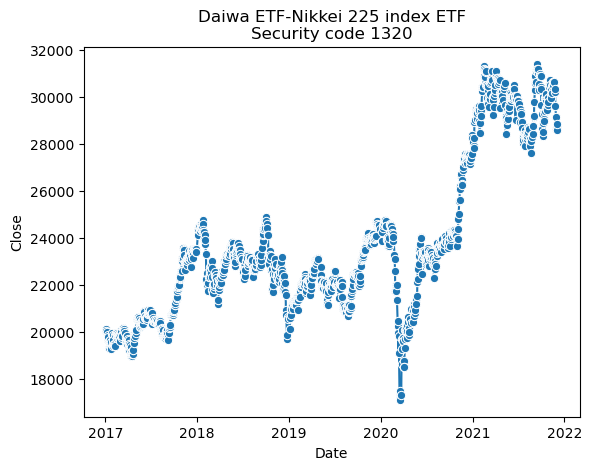

In [6]:
fig, ax = plt.subplots()
sns.lineplot(data = prices.loc[1320], x='Date', y='Close', marker='o')
market_index_name = stock_list.loc[1320, 'Name']
ax.set_title(f'{market_index_name} index ETF\nSecurity code 1320')

## Liquidity analysis

In [7]:
# Use the adjusted close and volume to compute the beta
train['CumulativeAdjustmentFactor'] = train.groupby('Code', group_keys=False)['AdjustmentFactor'].cumprod().shift(1)
train.loc[idx[:, '2017-01-04'], 'CumulativeAdjustmentFactor']=1

train['AdjClose'] = train['Close'] / train['CumulativeAdjustmentFactor']
train['AdjVolume'] = train['Volume'] * train['CumulativeAdjustmentFactor']

# train['AdjClose'] =train.groupby('Code', group_keys=False).apply(
#     lambda x: x['Close'] / (x['AdjustmentFactor'].cumprod()))
# train['AdjVolume'] =train.groupby('Code', group_keys=False).apply(
#     lambda x: x['Volume'] * (x['AdjustmentFactor'].cumprod()))
train['DollarVolume'] = train['AdjClose'] * train['AdjVolume']

In [8]:
stock_list['MeanDollarVolume'] = train['DollarVolume'].groupby('Code').mean()
stock_list['HighCapSecurities'] = stock_list['MarketCapitalization'] > 0.9*10**11
stock_list['LiquidSecurities'] = stock_list['MeanDollarVolume'] > 2e8


## Liquidity analysis

/home/rakin/miniconda3/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rakin/miniconda3/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rakin/miniconda3/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rakin/miniconda3/lib/python3.11/site-pac

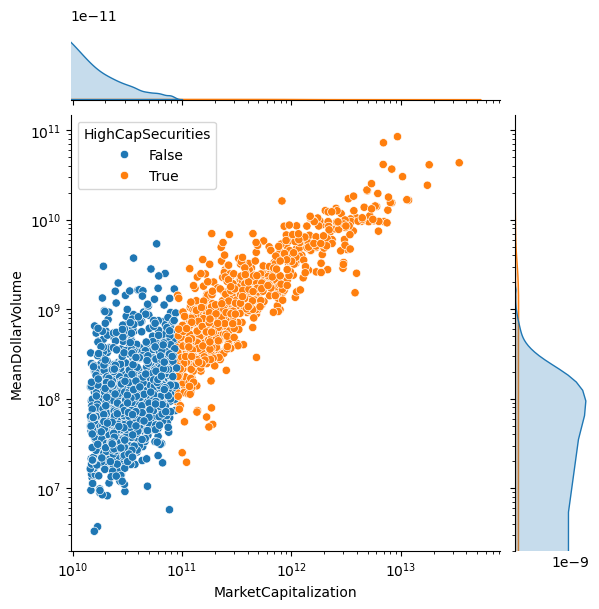

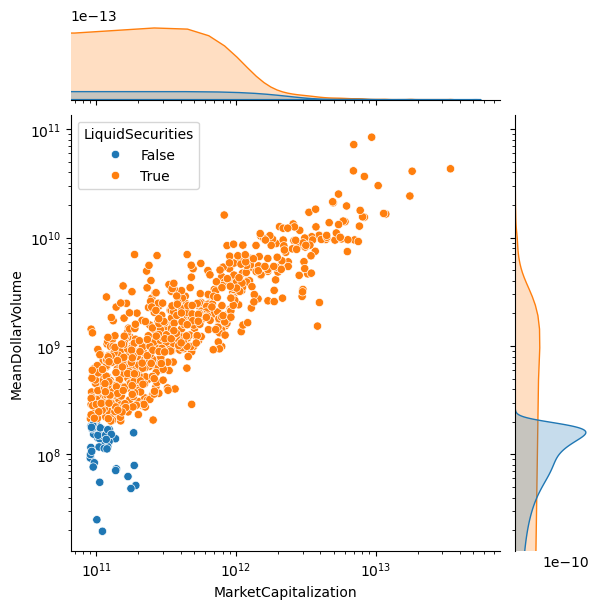

In [9]:
j = sns.jointplot(stock_list, x='MarketCapitalization', y='MeanDollarVolume', hue='HighCapSecurities')

j.ax_joint.set_xscale('log')
j.ax_joint.set_yscale('log')

j = sns.jointplot(stock_list.loc[stock_list['HighCapSecurities']],
                  x='MarketCapitalization', y='MeanDollarVolume', hue='LiquidSecurities', palette='tab10')
j.ax_joint.set_xscale('log')
j.ax_joint.set_yscale('log')

<font size =5>

* Note the x-axis and y-axis are in Japanese yen, not dollars.
* My universe will consist of stocks that have a market cap greater than 300 million yen.

## Constrain the universe to liquid securities with complete time series

In [10]:
universe_stats =stock_list.loc[
    np.logical_and(
        stock_list['CompleteTimeSeries'], 
        np.logical_and(
        stock_list['LiquidSecurities'], stock_list['HighCapSecurities']))].copy()

train = train.loc[universe_stats.index].copy()

# For some weird reason the bad outage day comes back into teh dataset
# This outage day is throwing of 45 periods of the target
train = train[train.index.get_level_values(1) != '2020-10-01'].copy()

print('Number of securities in the universe=', len(universe_stats.index))

Number of securities in the universe= 719


## Universe selection conclusion

<font size = 5>

* We've constrained our universe to be Japanese businesses.  The only ETF that is included in the universe list should be the Nikkei 225 ETF that we intentionally included to act as our market index. 
* Incomplete time series were removed.  There should be 1201 periods per security code.
* Small cap securities were removed.
* A singular bad day was removed October 1, 2020 because of an outage in the JPY exchange.

# Returns EDA

In [11]:
def plot_qq(series, dist='norm', title='Q-Q Plot', dist_params=None):
    """
    Generates a Q-Q plot for the given pandas Series, transformed according to the distribution.
    
    Parameters:
    - series (pd.Series): The data series to generate the Q-Q plot for. May contain NaNs.
    - dist (str): The theoretical distribution to compare against. Default is 'norm' (normal distribution).
    - title (str): Title of the Q-Q plot.
    - dist_params (tuple): Optional parameters for the distribution (for custom distributions like 'johnsonsu').
    """
    # Drop NaN values and ensure input is a pandas Series
    if not isinstance(series, pd.Series): 
        series = pd.Series(series)
    clean_series = series.dropna()
    
    # If the target distribution is 'norm', standardize the series
    if dist == 'norm':
        standardized_series = (clean_series - clean_series.mean()) / clean_series.std()
    
    # If using a custom distribution (e.g., 'johnsonsu', 't'), apply the CDF and PPF to transform the data
    else:
        if dist_params is None:
            raise ValueError(f"Distribution parameters (dist_params) must be provided for {dist}.")
        
        # Apply the CDF of the data (based on the fitted distribution)
        cdf_values = stats.__dict__[dist].cdf(clean_series, *dist_params)
        # Apply the PPF of the theoretical distribution to get the transformed quantiles
        standardized_series = stats.norm.ppf(cdf_values)

    # Generate Q-Q plot using the transformed series
    fig = plt.figure()
    
    # For custom distributions, we apply the correct distribution-specific transformations
    (theoretical_quantiles, ordered_values), regression_line = probplot(standardized_series, dist=dist, sparams=dist_params)
    
    # Plot the Q-Q points
    plt.plot(theoretical_quantiles, ordered_values, 'o', label='Data Points')
    
    # Plot the line of best fit
    plt.plot(theoretical_quantiles, regression_line[0] * theoretical_quantiles + regression_line[1], 'r-', label='Best Fit Line')
    
    # Add the y = x reference line
    plt.plot(theoretical_quantiles, theoretical_quantiles, 'k--', label='y = x (Reference Line)')
    
    # Add labels, title, and legend
    plt.title(title)
    plt.xlabel(f'Theoretical Quantiles of {dist} distribution')
    plt.ylabel(f'Ordered Values from {clean_series.name}')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

In [12]:
train['Return'] = train.groupby('Code', group_keys=False)['AdjClose'].pct_change(fill_method=None)
train['CumulativeReturn'] = train.groupby('Code', group_keys=False)['Return'].apply(
    lambda x: (1+x).cumprod())
train['LogReturn'] = train['Return'].apply(np.log1p)
train['ReturnFwd1d'] = train.groupby('Code', group_keys=False)['Return'].shift(-1)

# Since I'm not using the kaggle target I'll just drop it
train.drop('Target', axis=1, errors='ignore', inplace=True)

#OLD CODE
# there are some bad reporting days that cause the returns to be incorrect.
# In the original kaggle challenge, the target was simple returns shifted ahead by 2 days. 
# So the simple returns hsould be the target lagged by 2 periods.
# train['returns'] = train.groupby('Code', group_keys=False)['Target'].shift(2)

# OLD CODE that was meant to analyze outlier returns

# naughty_list = [1780, 1799, 1802, 1808, 1812, 1813, 1814, 1820, 1821, 1822]

# fig, ax = plt.subplots(len(naughty_list), 1, figsize=np.array([9.2, 5.6*len(naughty_list)/1.25]))

# for i, bad_ticker in enumerate(naughty_list):
#     ax[i].set_title(f'Security code:{bad_ticker}')
#     sns.lineplot(train.loc[bad_ticker], x='Date', y='AdjClose', ax=ax[i])
#     sns.scatterplot(train.loc[bad_ticker], x='Date', y='CumulativeAdjustmentFactor', ax=ax[i].twinx(), color='tab:orange')



## Universe statistics

<font size = 4>

Groupby the security code and compute statistics on the daily `Return`

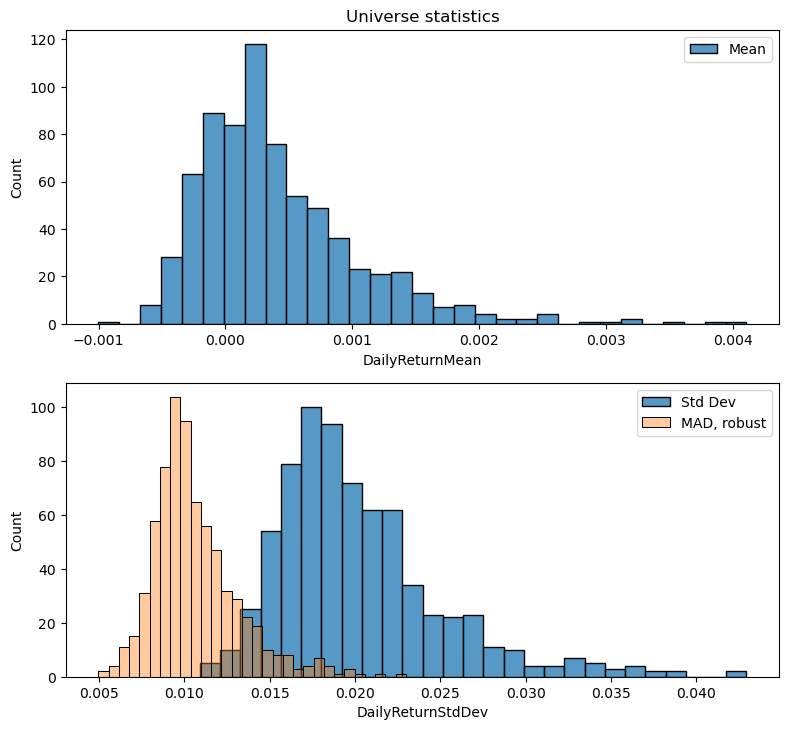

In [13]:
universe_stats['OverallReturn'] = train.groupby('Code', group_keys=False)['CumulativeReturn'].apply(lambda x: x.iloc[-1])
universe_stats['DailyReturnMean'] = train.groupby('Code', group_keys=False)['Return'].mean()
universe_stats['DailyReturnStdDev'] = train.groupby('Code', group_keys=False)['Return'].std()
universe_stats['DailyReturnMedian'] = train.groupby('Code', group_keys=False)['Return'].median()
universe_stats['DailyReturnMAD'] = train.groupby('Code', group_keys=False)['Return'].apply(
    lambda x: np.abs((x - x.median())).median()
)

fig, ax = plt.subplots(2, 1, figsize = (9.2, 5.6*1.5))
axa, axb = ax

axa.set_title('Universe statistics')

sns.histplot(universe_stats, x='DailyReturnMean', label='Mean', ax=axa)

sns.histplot(universe_stats, x='DailyReturnStdDev', label='Std Dev', ax=axb)
sns.histplot(universe_stats, x='DailyReturnMAD', label='MAD, robust', ax=axb, alpha=0.4 )

axa.legend()
axb.legend()



<font size = 5>

* Top histogram
    * Median returns is excluded because those are typically zero
    * Asymmetry in the mean daily returns is expected

* Bottom plot
    * The median absolute deviation (MAD) estimate is a more conservative estimate of the spread in the daily returns.
    * Elements of Quantitative Investing by Paleologo suggests using MAD to winsorize returns.

## Returns winsorization

Source: GA Paleologo Elements of Quantitative Investing

<img src='figures/gappy-winsorization.png'>

In [14]:
def Winsorize_robustZ(series: pd.Series, fraction):
    """
    Winsorizes the input series based on robust Z-scores, computed from the median absolute deviation (MAD).
    
    Parameters:
    - series (pd.Series): Input data series to be winsorized.
    - fraction (float): The fraction of the data to be winsorized (e.g., 0.997).

    Returns:
    - pd.DataFrame: DataFrame containing the winsorized series, z-score quantile, and winsor limit.
    """
    # Calculate the median absolute deviation (MAD)
    mad = np.abs(series - series.median()).median()
    
    # Compute the robust Z-score
    robust_zscore = np.abs(series - series.median()) / mad
    
    # Determine the quantile for winsorization
    zscore_quantile = robust_zscore.quantile(fraction)
    
    # Ensure the quantile is between the defined bounds of 5 and 10
    zscore_quantile = max(3, min(zscore_quantile, 10))
    
    # Calculate the winsorization limit
    winsor_limit = (robust_zscore >= zscore_quantile).mean()
    
    # Winsorize the series based on the robust Z-score
    winsorized_zscore = winsorize(robust_zscore, limits=winsor_limit, nan_policy='omit')
    
    # Scale back to the original series
    winsorized_series = pd.Series(
        winsorized_zscore * mad * np.sign(series - series.median()).values + series.median(),
        index=series.index)
    
    # Return a DataFrame containing the winsorized series, quantile, and limit
    output = {
        'winsorized_series': winsorized_series,
        'zscore_quantile': zscore_quantile,
        'winsor_limit': winsor_limit
    }
    return pd.DataFrame(output, index=series.index)



def WinsorizeReturns_robustZ(series:pd.Series, fraction):
    log_return = series.apply(np.log1p)
    mad = log_return.apply(np.abs).median()

    # mind the absolute value sign on the numerator
    robust_zscore = np.abs(log_return) / mad

    # Use a single tailed quanitle
    zscore_quantile = robust_zscore.quantile(fraction) 

    # The quantile to clip should be no smaller than 5,
    # and no larger than 10 (ref: EQI Gappy)
    zscore_quantile = max(5, min(zscore_quantile, 10))
    winsor_limit = (robust_zscore >= zscore_quantile).mean()

    winsorized_zscore = winsorize(robust_zscore, limits=winsor_limit, nan_policy='omit')
    winsorized_series = pd.Series(
        winsorized_zscore * mad * np.sign(log_return).values,
        index=series.index)
    output = {
        'winsorized_series': winsorized_series,
        'zscore_quantile': zscore_quantile,
        'winsor_limit': winsor_limit
    }
    return pd.DataFrame(output, index=series.index)

winsor_fraction = 0.997 # TUNE THIS PARAMETER BY HAND
winsorized_result = train.groupby('Code', group_keys=False)['Return'].apply(
    WinsorizeReturns_robustZ, fraction=winsor_fraction)

train['WinsorReturn'] = winsorized_result['winsorized_series']
universe_stats['winsor_limit'] = winsorized_result['winsor_limit'].groupby('Code').mean()
universe_stats['robustZ_WinsorCutoff'] = winsorized_result['zscore_quantile'].groupby('Code').mean()

train['WinsorCumulativeReturn'] = train.groupby('Code', group_keys=False)['WinsorReturn'].apply(
    lambda x: (1+x).cumprod()
)

Text(0.5, 0, '$d_{max}$')

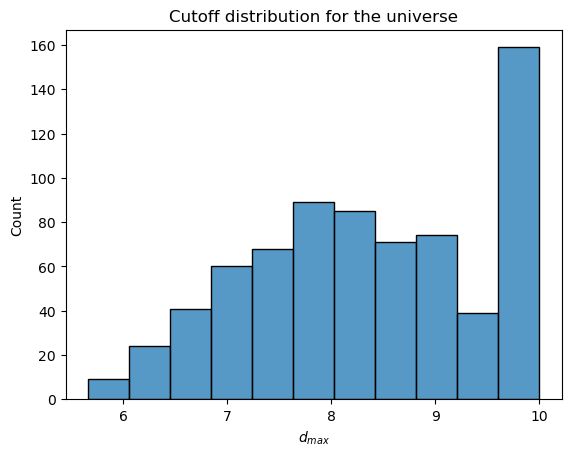

In [15]:
fig, ax = plt.subplots()

sns.histplot(universe_stats, x='robustZ_WinsorCutoff')
ax.set_title('Cutoff distribution for the universe')
ax.set_xlabel(r'$d_{max}$')
# sns.histplot(universe_stats, x='winsor_limit')

<font size = 4>

* GA Paleologo recommends to use winsorization on the aboslute value of the robust z score of the returns.
* The cutoff should be between 5 and 10, and fine tuned by trial and error.
* Using a `fraction=0.994` or a winsorization limit of 0.6%, the cutoff's are roughly centrally distributed around 7.
* The fat tail at 10 must be coming from securities that had massive growth and decline.  

Code
4523    0.012490
7412    0.011657
2158    0.009159
6502    0.008326
9201    0.008326
9715    0.008326
2212    0.007494
2432    0.007494
6366    0.007494
7752    0.007494
Name: winsor_limit, dtype: float64

<Axes: title={'center': 'Security code 4523'}, xlabel='Date', ylabel='CumulativeReturn'>

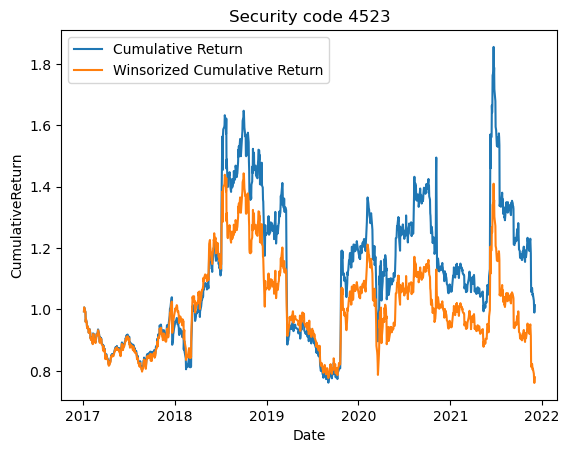

In [16]:
display(universe_stats['winsor_limit'].nlargest(10))
fig, ax = plt.subplots()

security = 4523
ax.set_title(f'Security code {security}')
sns.lineplot(train.loc[security], x='Date', y='CumulativeReturn', label='Cumulative Return')
sns.lineplot(train.loc[security], x='Date', y='WinsorCumulativeReturn', label='Winsorized Cumulative Return')

<font size=5>

* Security 9873 had to be winsorized the most, with 6.5% of its returns being winsorized.

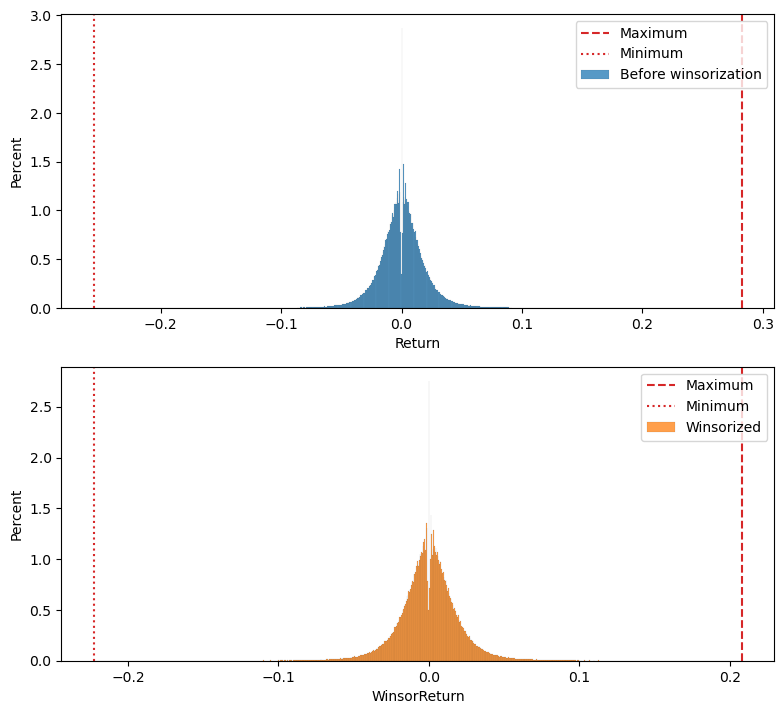

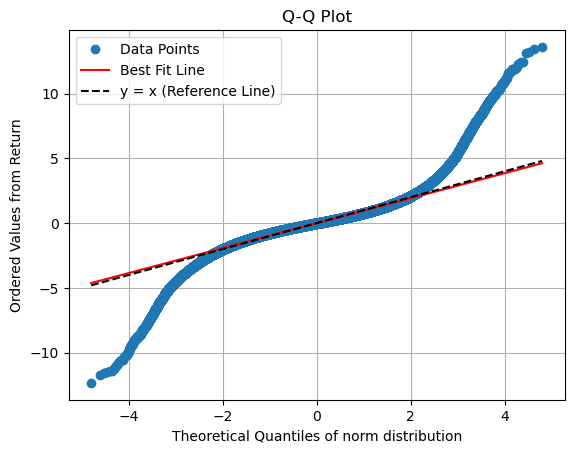

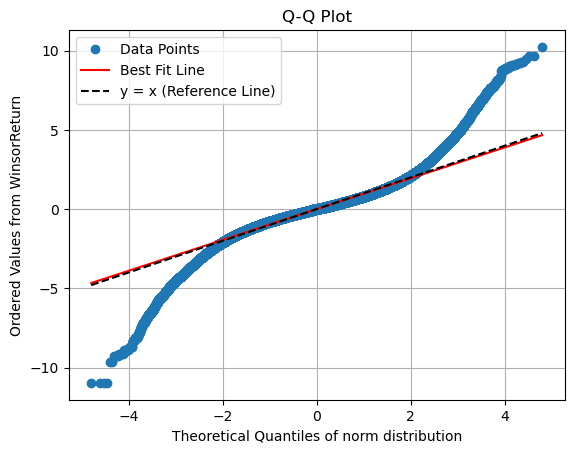

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(9.2, 5.6*1.5))
sns.histplot(train, x='Return', label='Before winsorization', stat='percent', ax=ax[0])
ax[0].axvline(train['Return'].max(), color='tab:red', linestyle='--', label='Maximum')
ax[0].axvline(train['Return'].min(), color='tab:red', linestyle=':', label='Minimum')


sns.histplot(train, x='WinsorReturn', label='Winsorized', stat='percent', color='tab:orange', ax=ax[1])
ax[1].axvline(train['WinsorReturn'].max(), color='tab:red', linestyle='--', label='Maximum')
ax[1].axvline(train['WinsorReturn'].min(), color='tab:red', linestyle=':', label='Minimum')
for a in ax: a.legend()


plot_qq(train['Return'])
plot_qq(train['WinsorReturn'])



<font size = 5>

* There are so many zero return days because the data source rounded the prices to the nearest yen. 

* The extent of the winsorized return distribution is reduced, with max and min at $\approx \pm 0.25$

* The Q-Q plot of the Winsorized returns has slightly less heavy tails. 

# Calculating $\beta$

$$
\beta_e = \frac{\text{Cov}(R_{e}, R_{m})}{\text{Var}(R_m)}
$$
* $\beta_e$ explains the contribution of volatility in an equity that is derived from the systematic risk in the overall market.
* $R_e$ is the daily return of a stock price.
* $R_m$ is the daily return in a market index.

An appropriate estimator for the covariance of two random variables would be

$$
\text{Cov}(X, Y) = \frac{1}{n-1} \sum_{i=1}^{n}{ \left(X_i - \bar{X}\right) \left(Y_i - \bar{Y}\right)}
$$

Where $\bar{X}$ is the estimator for the mean of $X$.  Estimators for covariance and mean should converge to their true population statistic by WLLN.  If we set $n=45$ and using a moving average approach, we can compute the 45 day $\beta$.

Targets:
* Forecast the 45 day average $beta$ for the next day
* Forecast the 45 day average $beta$ 45 days from now
 
 Checking the autocorrelation of the $\beta$ would indicate how hard it is to forecast $\beta$ far into the future.

 Note $\beta$ is also the coefficient if we regress the stock returns against the market returns (and could be computed from matrix multiplication and inversion of $A^TA$).


* `beta_45avg` is computed using 45 days of returns of a stock and the market.  This is a "historical" beta that depends on data that has been recorded.
* `beta_45avg_1` would be tomorrow's 45 day averaged beta.  We should expect this time series to have strong correlation with the historical `beta_45avg` because only 1/45 days is unknown to us, and is likely to have weak contribution in comparison to the other 44 days.
* A natural thing to check would be the autocorrelation.

In [18]:
market_df = train.loc[1320]
# forecast window
target_window_span = 45
# forward_window = pd.api.indexers.FixedForwardWindowIndexer(window_size=target_window_span)

def wavelet_smooth(signal, threshold = 0.2, level =3, wavelet = 'db6'):

    coeff = pywt.wavedec(signal, wavelet, mode = 'per', level =level)
    coeff[1:]  = [pywt.threshold(i, value=threshold*np.abs(signal.max()), mode = 'soft') for i in coeff[1:]]
    clean_signal = pywt.waverec(coeff, wavelet, mode = 'per')
    # return clean_signal
    if len(signal)%2 == 1:
        clean_series= pd.Series(clean_signal[:-1], signal.index)
    else:
        clean_series =  pd.Series(clean_signal, signal.index)
    return clean_series

def rolling_beta(df:pd.DataFrame, rolling_window, column, market_df=market_df):
    Y_series= df[column]
    X_series = market_df[column]
    XY_series = X_series * Y_series
    XY_mean = XY_series.rolling(window=rolling_window).mean()
    X_mean = X_series.rolling(window=rolling_window).mean()
    Y_mean = Y_series.rolling(window=rolling_window).mean()
    X_variance = X_series.rolling(window=rolling_window).var()
    return (XY_mean - X_mean * Y_mean) / X_variance


train['beta_45avg']=train.groupby('Code', group_keys=False).apply(
    rolling_beta, rolling_window=target_window_span, column='WinsorReturn'
)

# we use ffill to populate time series who's values we are unsure of.
# bfill would constitute a lookahead bias, who's severity would depend on 
# the span of the averaging window.
# train['beta_target_1'] =  train.groupby('Code', group_keys=False)['beta_45avg'].shift(-1).ffill()
# train['beta_target_5'] =  train.groupby('Code', group_keys=False)['beta_45avg'].shift(-5).ffill()
# train['beta_target_20'] = train.groupby('Code', group_keys=False)['beta_45avg'].shift(-20).ffill()
# train['beta_target_45'] = train.groupby('Code', group_keys=False)['beta_45avg'].shift(-45).ffill()


# OLD CODE
# train['beta_target']=train['beta_target_45']
# train['dbeta'] = train.groupby('Code', group_keys=False)['beta_target'].apply(lambda x: x.diff().fillna(x.diff().mean()))
# train['dbeta_sm']=train.groupby('Code', group_keys = False)['dbeta'].apply(wavelet_smooth, level = 4, threshold = 0.15)


## Distribution of $\beta$

In [19]:
# universe_stats = pd.DataFrame(index = train.index.get_level_values(0).unique())
universe_stats['avg_beta'] = train.groupby('Code', group_keys=False)['beta_45avg'].mean()
universe_stats['beta_rank'] = np.abs(universe_stats.avg_beta).rank(ascending = False)
universe_stats.sort_values(by = 'beta_rank',inplace=True)

top3_betas = universe_stats.head(3).index.get_level_values('Code').to_list()
bottom3_betas = universe_stats.tail(3).index.get_level_values('Code').to_list()

median_beta = universe_stats['avg_beta'].median()
universe_stats['distance_from_median'] = (universe_stats['avg_beta'] - median_beta).abs()
median_betas = universe_stats.nsmallest(3, 'distance_from_median').index.get_level_values('Code').to_list()
universe_stats.drop(columns=['distance_from_median'], inplace=True)



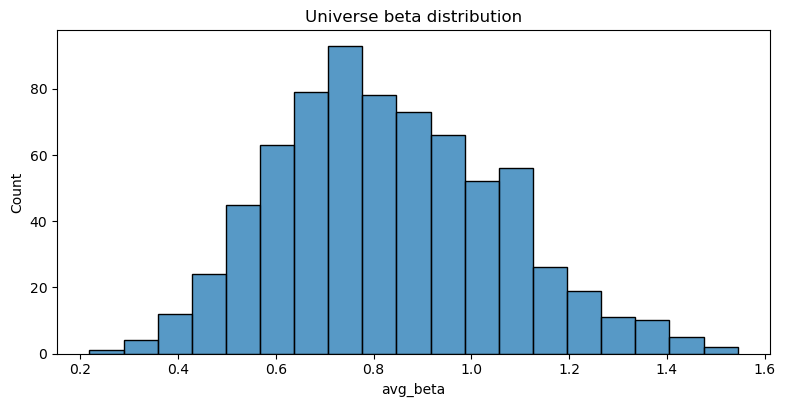

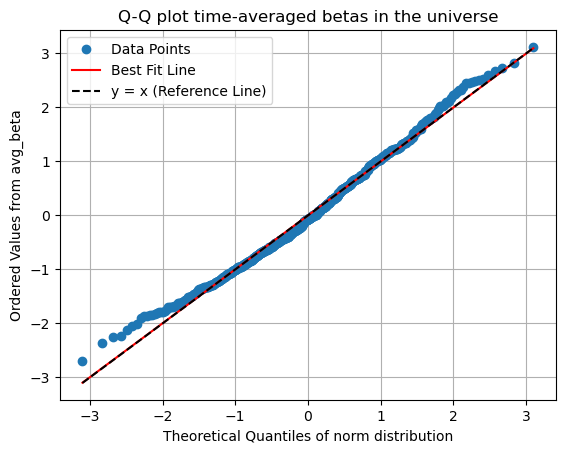

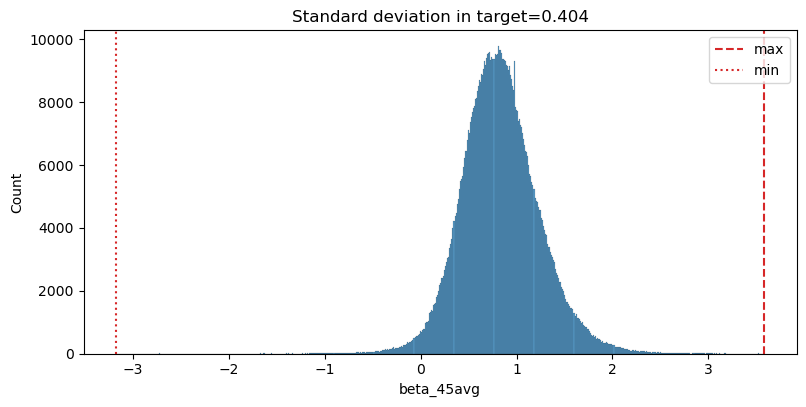

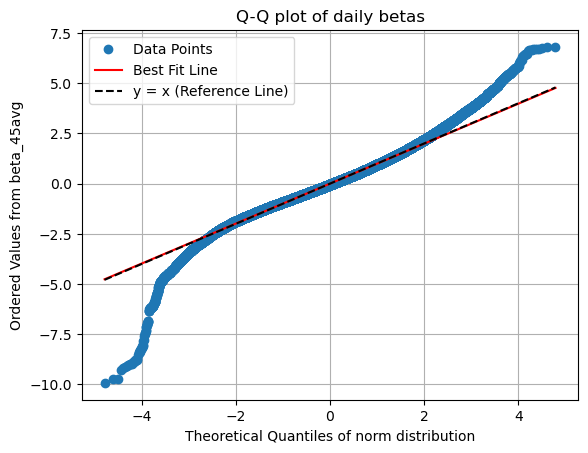

In [20]:
fig, axa = plt.subplots(1, 1, figsize=(9.2, 5.6*1.5/2))
sns.histplot(universe_stats, x='avg_beta', ax=axa)
# ax a
axa.set_title('Universe beta distribution')
plot_qq(universe_stats['avg_beta'], title='Q-Q plot time-averaged betas in the universe')


fig, axb = plt.subplots(1, 1, figsize=(9.2, 5.6*1.5/2))
sns.histplot(train, x='beta_45avg', ax=axb)



# ax b
axb.axvline(train['beta_45avg'].max(), linestyle='--', color='tab:red',label='max' )
axb.axvline(train['beta_45avg'].min(), linestyle=':', color='tab:red', label='min')

beta_stdev = train['beta_45avg'].std()
axb.set_title('Standard deviation in target={:.3g}'.format(beta_stdev))

axb.legend()

plot_qq(train['beta_45avg'], title='Q-Q plot of daily betas')

<font size=5>

* The Q-Q plot reveals that the unconditional distribution of $\beta$ has fat tails.
* Thinning these tails with a transformation will help reduce the impacts of outliers/extreme values in the dataset.
* A Johnson-SU transformation will be used to help roughly normalize the data.

In [21]:
def johnson_su_transform(series: pd.Series):
    """
    Transforms a pandas series to a more normal distribution using Johnson SU.
    
    Parameters:
    - series (pd.Series): Input data series to be transformed.
    
    Returns:
    - transformed_series (pd.Series): Transformed series that is more normally distributed.
    - jsu_params (tuple): Parameters of the fitted Johnson SU distribution.
    """
    jsu_params = johnsonsu.fit(series.dropna())
    uniform_values = johnsonsu.cdf(series.dropna(), *jsu_params)
    normal_transformed_values = norm.ppf(uniform_values)
    transformed_series = pd.Series(normal_transformed_values, index=series.dropna().index)

    return transformed_series, jsu_params

def johnson_su_inverse_transform(transformed_series: pd.Series, jsu_params: tuple):
    """
    Inverse transform a Johnson SU-normalized series back to its original distribution.
    
    Parameters:
    - transformed_series (pd.Series): The transformed (normalized) series.
    - jsu_params (tuple): The parameters of the Johnson SU distribution.
    
    Returns:
    - original_series (pd.Series): The series transformed back to its original distribution.
    """
    uniform_values = norm.cdf(transformed_series)
    original_values = johnsonsu.ppf(uniform_values, *jsu_params)
    original_series = pd.Series(original_values, index=transformed_series.index)

    return original_series


def tail_specific_transform(series, left_threshold, transformation='log'):
    """
    Applies a tail-specific transformation on the left tail of the series.
    
    Parameters:
    - series (pd.Series): Input series to transform.
    - left_threshold (float): The threshold below which the left tail transformation will be applied.
    - transformation (str): Type of transformation to apply ('log' for log-transform).
    
    Returns:
    - transformed_series (pd.Series): Transformed series with the left tail adjusted.
    """
    # Create a copy to avoid modifying the original data
    transformed_series = series.copy()
    
    # Apply a log transform to values in the left tail
    if transformation == 'log':
        left_tail = transformed_series < left_threshold
        # Transform with sign preservation
        transformed_series[left_tail] = np.log1p(np.abs(transformed_series[left_tail])) * np.sign(transformed_series[left_tail])
    
    return transformed_series


def tail_specific_inverse_transform(series, left_threshold, transformation='log'):
    """
    Inverse of the tail-specific log transformation applied to the left tail.
    
    Parameters:
    - series (pd.Series): Input transformed series.
    - left_threshold (float): The threshold below which the left tail was transformed.
    - transformation (str): The type of transformation applied ('log').
    
    Returns:
    - inverse_transformed_series (pd.Series): Series after reversing the log transformation on the left tail.
    """
    # Create a copy to avoid modifying the original data
    inverse_transformed_series = series.copy()
    transformed_left_threshold = np.expm1(left_threshold) * np.sign(left_threshold)
    transformed_left_threshold = np.log1p(np.abs(left_threshold))*np.sign(left_threshold)
    # val_neg = np.expm1(-left_threshold); print(val_neg)
    # val_pos = np.expm1(left_threshold); print(val_pos)

    # if val_pos>val_neg: 
    #     transformed_left_threshold = val_pos
    # else:
    #     transformed_left_threshold = -1*val_neg
    print(transformed_left_threshold)
    if transformation == 'log':
        left_tail = inverse_transformed_series < transformed_left_threshold
        # Inverse transform with sign preservation
        z = series[left_tail].copy()
        x1 = np.expm1(z)
        x2 = np.expm1(-z)
        x = np.empty_like(x1)
        x[x1>x2] = x1[x1>x2]
        x[x1<x2] = x2[x1<x2]
        print(np.shape(x))
        print(np.shape(inverse_transformed_series[left_tail]))
        # inverse_transformed_series[left_tail] = (np.expm1(np.abs(inverse_transformed_series[left_tail]))) * np.sign(inverse_transformed_series[left_tail])
        inverse_transformed_series[left_tail] = x
    
    return inverse_transformed_series


# This function will first undo the log transformation, then undo the Johnson SU transformation
def full_inverse_transform(series, jsu_params, left_threshold):
    """
    Inverts the tail-specific log transformation and the Johnson SU transformation.
    
    Parameters:
    - series (pd.Series): Transformed series that needs to be inverted.
    - jsu_params (tuple): Parameters from the Johnson SU distribution.
    - left_threshold (float): The threshold for the tail-specific transformation.
    
    Returns:
    - original_series (pd.Series): Series restored to its original form.
    """
    # Step 1: Undo the tail-specific log transformation
    series_after_tail_inverse = tail_specific_inverse_transform(series, left_threshold=left_threshold)
    
    # Step 2: Undo the Johnson SU transformation
    original_series = johnson_su_inverse_transform(series_after_tail_inverse, jsu_params)
    
    return original_series

In [22]:
# # Apply Johnson SU transformation to the data
# train['beta_45avg_jsunorm'], jsu_params = johnson_su_transform(train['beta_45avg'])
# # train['beta_45avg_norm_inv'] = johnson_su_inverse_transform(train['beta_45avg_norm'], jsu_params)

# # Set up subplots
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# sns.histplot(train, x='beta_45avg', stat='density', label='Original Data', ax=ax[0], color='blue')
# x_values = np.linspace(train['beta_45avg'].min(), train['beta_45avg'].max(), 1000)
# johnsonsu_pdf = johnsonsu.pdf(x_values, *jsu_params)
# ax[0].plot(x_values, johnsonsu_pdf, 'r-', lw=2, label='Johnson SU Fit')
# ax[0].set_title(r'Original $\beta$ (Johnson SU)')
# ax[0].set_xlabel('beta_45avg')
# ax[0].legend()

# sns.histplot(train, x='beta_45avg_jsunorm', stat='density', label='Transformed Data', ax=ax[1], color='green')
# x_values_transformed = np.linspace(train['beta_45avg_jsunorm'].min(), train['beta_45avg_jsunorm'].max(), 1000)
# normal_pdf = norm.pdf(x_values_transformed, loc=0, scale=1)  # Standard normal distribution
# ax[1].plot(x_values_transformed, normal_pdf, 'r-', lw=2, label='Normal Gaussian Fit')
# ax[1].set_title(r'Johnson SU transformed $\beta$')
# # ax[1].set_xlabel('Transformed Values')
# ax[1].legend()

# plot_qq(train['beta_45avg_jsunorm'], title='Q-Q Plot of Johnson SU Transformed Data')


In [23]:


# # Apply the tail-specific transformation
# left_threshold = -4  # Adjust this based on your distribution
# train['beta_45avg_jsutailnorm'] = tail_specific_transform(train['beta_45avg_jsunorm'], left_threshold=left_threshold)

# # Visualize the original Johnson SU transformed data and the tail-specific transformed data
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# # Original Johnson SU transformed data
# sns.histplot(train, x='beta_45avg_jsunorm', stat='density', label='Johnson SU Transformed Data', ax=ax[0], color='blue')
# ax[0].set_title('Johnson SU Transformed Data')
# ax[0].set_xlabel('beta_45avg_jsunorm')

# # Tail-specific transformed data
# sns.histplot(train, x='beta_45avg_jsutailnorm', stat='density', label='Tail-Specific Transformed Data', ax=ax[1], color='green')
# ax[1].set_title('Tail-Specific Transformed Data')
# ax[1].set_xlabel('beta_45avg_jsutailnorm')

# plt.tight_layout()
# plt.show()

# # Optional: Q-Q plot to verify if the tail-specific transformation improved normality
# plot_qq(train['beta_45avg_jsutailnorm'], dist='norm', title='Q-Q Plot of Tail-Specific Transformed Data')

# train['beta_45avg_norm'] = train['beta_45avg_jsutailnorm']
# train['beta_45avg_norm'] = train['beta_45avg_jsunorm']

### Transformation inversion 

In [24]:
# train['beta_45avg_original'] = johnson_su_inverse_transform(train['beta_45avg_norm'], jsu_params=jsu_params)
# fig, ax = plt.subplots()

# sns.scatterplot(train, x='beta_45avg', y='beta_45avg_original')
# plot_qq(train['beta_45avg_original'])

<font size = 5>

* The normalized $\beta$ has a thin right tail now, and a less heavy left tail, through a Johnson SU transformation

### Creating targets

In [25]:
# train['beta_1target_norm'] =  train.groupby('Code', group_keys=False)['beta_45avg_norm'].shift(-1)
# train['beta_5target_norm'] =  train.groupby('Code', group_keys=False)['beta_45avg_norm'].shift(-5)
# train['beta_20target_norm'] = train.groupby('Code', group_keys=False)['beta_45avg_norm'].shift(-20)
# train['beta_45target_norm'] = train.groupby('Code', group_keys=False)['beta_45avg_norm'].shift(-45)


train['beta_1target'] =  train.groupby('Code', group_keys=False)['beta_45avg'].shift(-1)
train['beta_5target'] =  train.groupby('Code', group_keys=False)['beta_45avg'].shift(-5)
train['beta_20target'] = train.groupby('Code', group_keys=False)['beta_45avg'].shift(-20)
train['beta_45target'] = train.groupby('Code', group_keys=False)['beta_45avg'].shift(-45)


<font size = 4>

* Top plot is a distribution of the average $\beta$ in the universe
* Bottom plot is a distribution of the $\beta$ in the entire dataset
* The Q-Q plot suggests the daily $\beta$ has fat tails.  

## Autocorrelation in the 45 day $\beta$

$$
\rho(k) = \frac{ \text{Cov}(X_t, X_{t-k}) } { \text{Var}(X_t) }
$$

Where $\rho(k)$ is a measure of how correlated a time series is with itself, but lagged by a period of $k$

Text(0, 0.5, 'Autocorrelation')

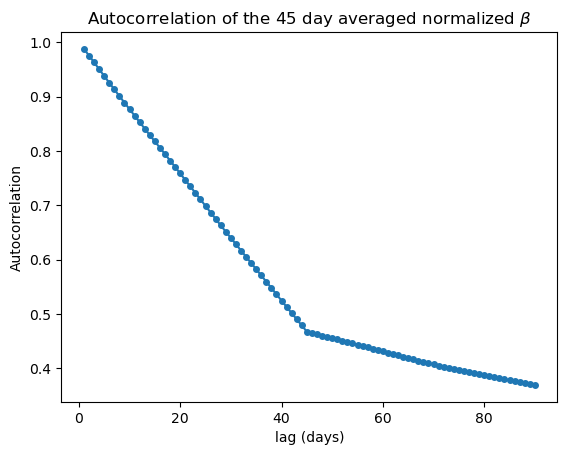

In [26]:
beta_autocorrelation = np.array([
    train['beta_45avg'].autocorr(i) for i in range (1, 91)
])

# train['beta_45avg'].autocorr(4)
fig, ax = plt.subplots()
ax.plot(np.arange(1, 91),beta_autocorrelation, 'o-', markersize = 4)
ax.set_title(r'Autocorrelation of the 45 day averaged normalized $\beta$ ')
ax.set_xlabel(r'lag (days)')
ax.set_ylabel(r'Autocorrelation')

# ax.axhline(0.7, color='k', linestyle='--')

* The broad minimum near the 65 day lag seems a little strange, but the fact that it's extremely broad makes me less concerned.

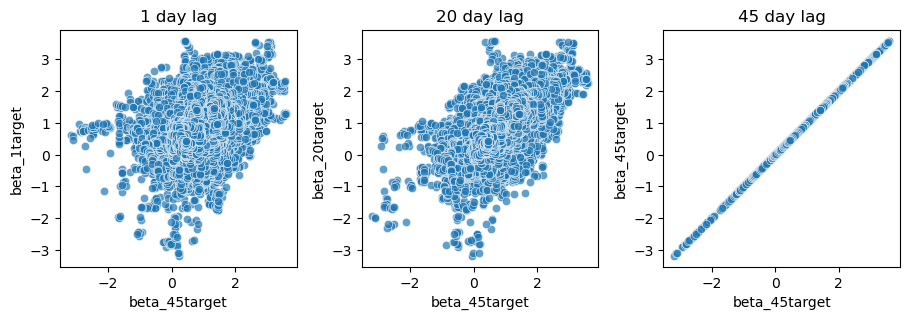

In [27]:
fig, ax = plt.subplots(1, 3, tight_layout=True, figsize = (9.2, 5.6))


sns.scatterplot(train, x='beta_45target', y='beta_1target' , alpha = 0.7, ax=ax[0]) 
sns.scatterplot(train, x='beta_45target', y='beta_20target',  alpha = 0.7, ax=ax[1])
sns.scatterplot(train, x='beta_45target', y='beta_45target',  alpha = 0.7, ax=ax[2])

ax[0].set_title('1 day lag')
ax[1].set_title('20 day lag')
ax[2].set_title('45 day lag')
for a in ax: a.set_aspect('equal')

* The autocorrelation seems to plateau past a lag of ~42 periods.  
* Forecasting the 45 day average $\beta$, 45 days from now seems to be as tough as it gets.

This qualitatively makes a lot of sense. If the lag, $k$ is less than the window span, then I don't really have to forecast a 45 day statistic, I only have to forecast a statistic over the span of $k$ days.


## View a few $\beta$ time series
* To give some confidence we've computed the $\beta$ correctly, we might just look at their time series for a few stocks.  
* We'll look at the top 3 beta stocks, the median 3 beta stocks, and the 3 lowest $\beta$ stocks.

In [28]:
def plot_target_timeseries(tickers:list, features:list=None, targets:list=None, df:pd.DataFrame =None):
    if df ==None: df =  train
    if targets == None: targets = ['beta_45target']
    if features == None: features = ['CumulativeReturn']
    # targets = ['CumulativeReturn'] + targets

    fig, ax = plt.subplots(len(tickers), 2, figsize = (14,10))
    for i, tick in enumerate(tickers):
        ax[i, 0].set_title('Security code {:}'.format(tick))
        ax[i, 1].set_title('beta rank {:}\n mean beta={:.3g}'.format(*universe_stats.loc[tick, ['beta_rank', 'avg_beta']]))
        for targ in targets:
            sns.lineplot(df.loc[tick], x= 'Date', y=targ, ax=ax[i, 1], marker='o', label=targ)
        for feat in features:
            sns.lineplot(df.loc[tick], x='Date', y=feat, ax=ax[i, 0], marker='o', label=feat)            
    for a in ax[0]: a.legend()
    for a in ax[1]: a.legend()
    fig.tight_layout()

### Top 3 high $\beta$ stocks

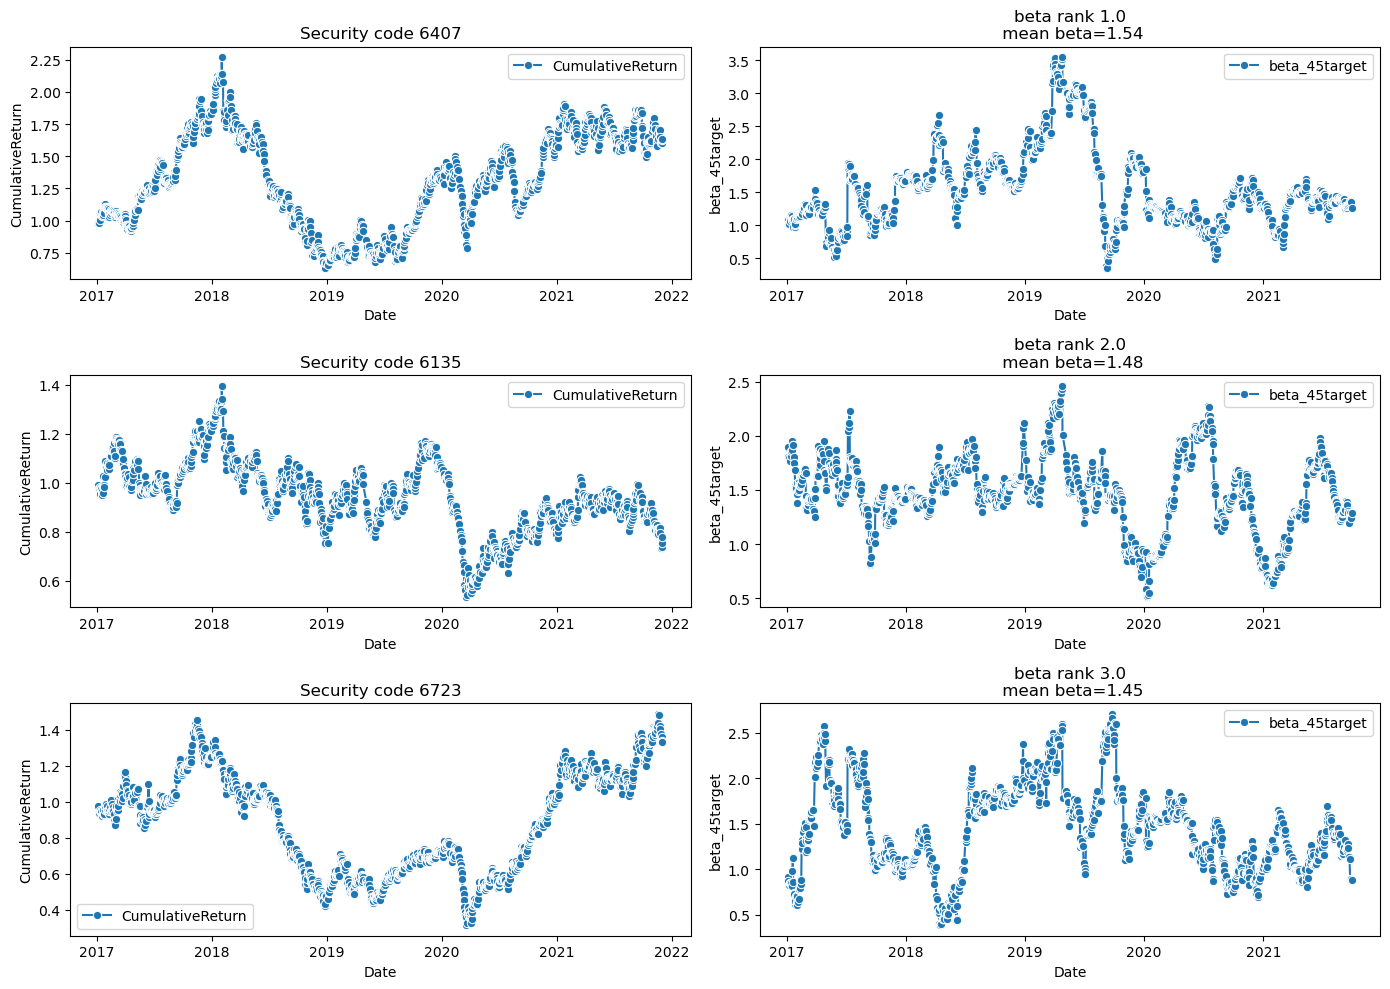

In [29]:
plot_target_timeseries(top3_betas, features=['CumulativeReturn'], targets=['beta_45target'])

### Median $\beta$ stocks

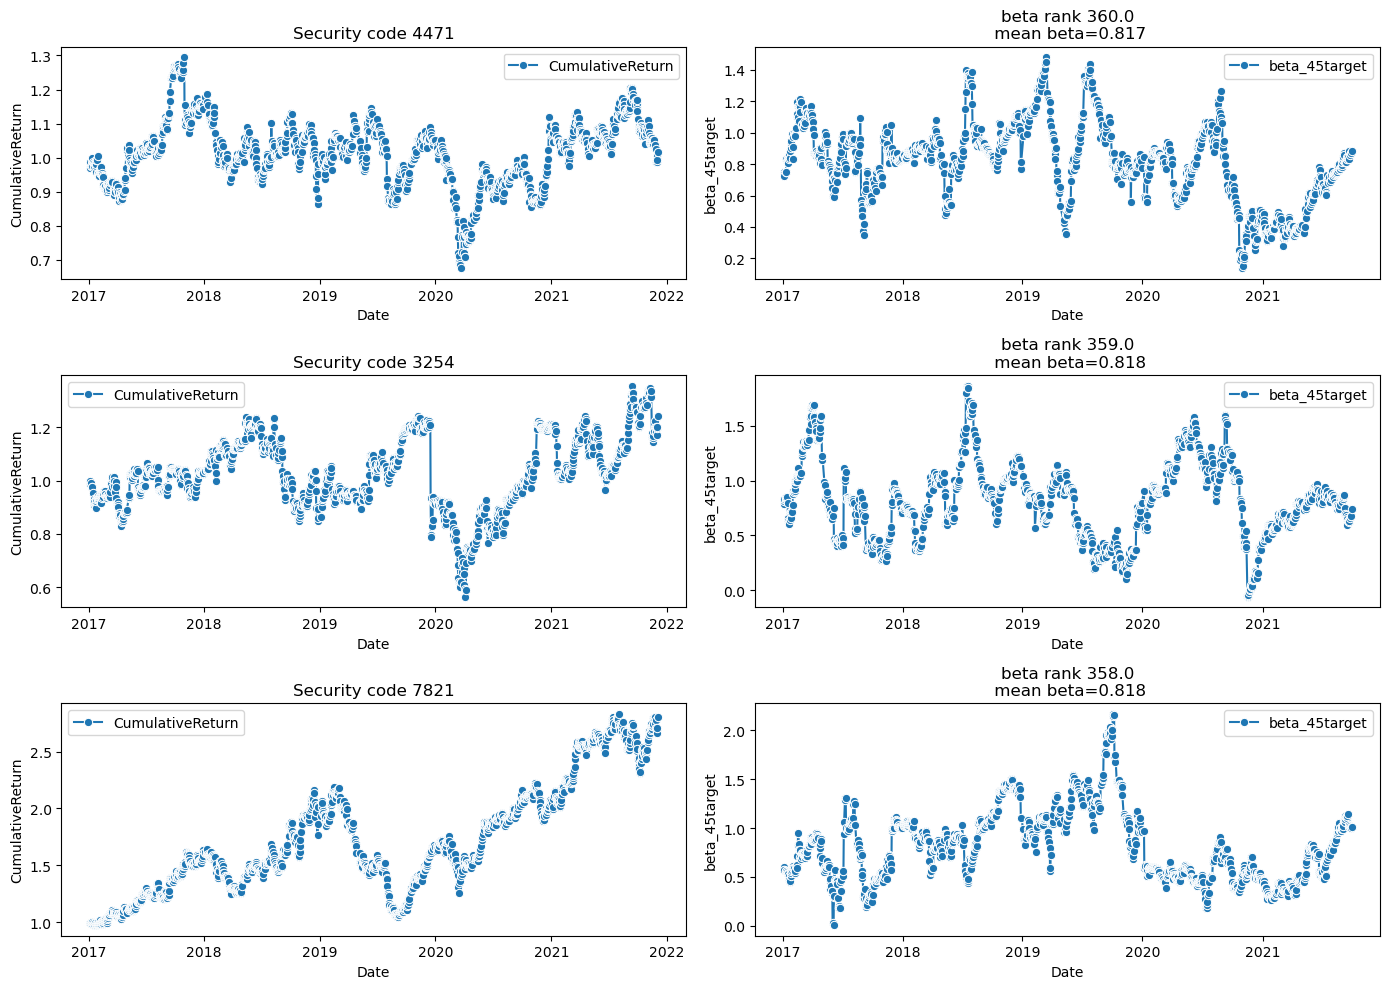

In [30]:
plot_target_timeseries(median_betas, features=['CumulativeReturn'], targets=['beta_45target'])

### Bottom 3 $\beta$ stocks

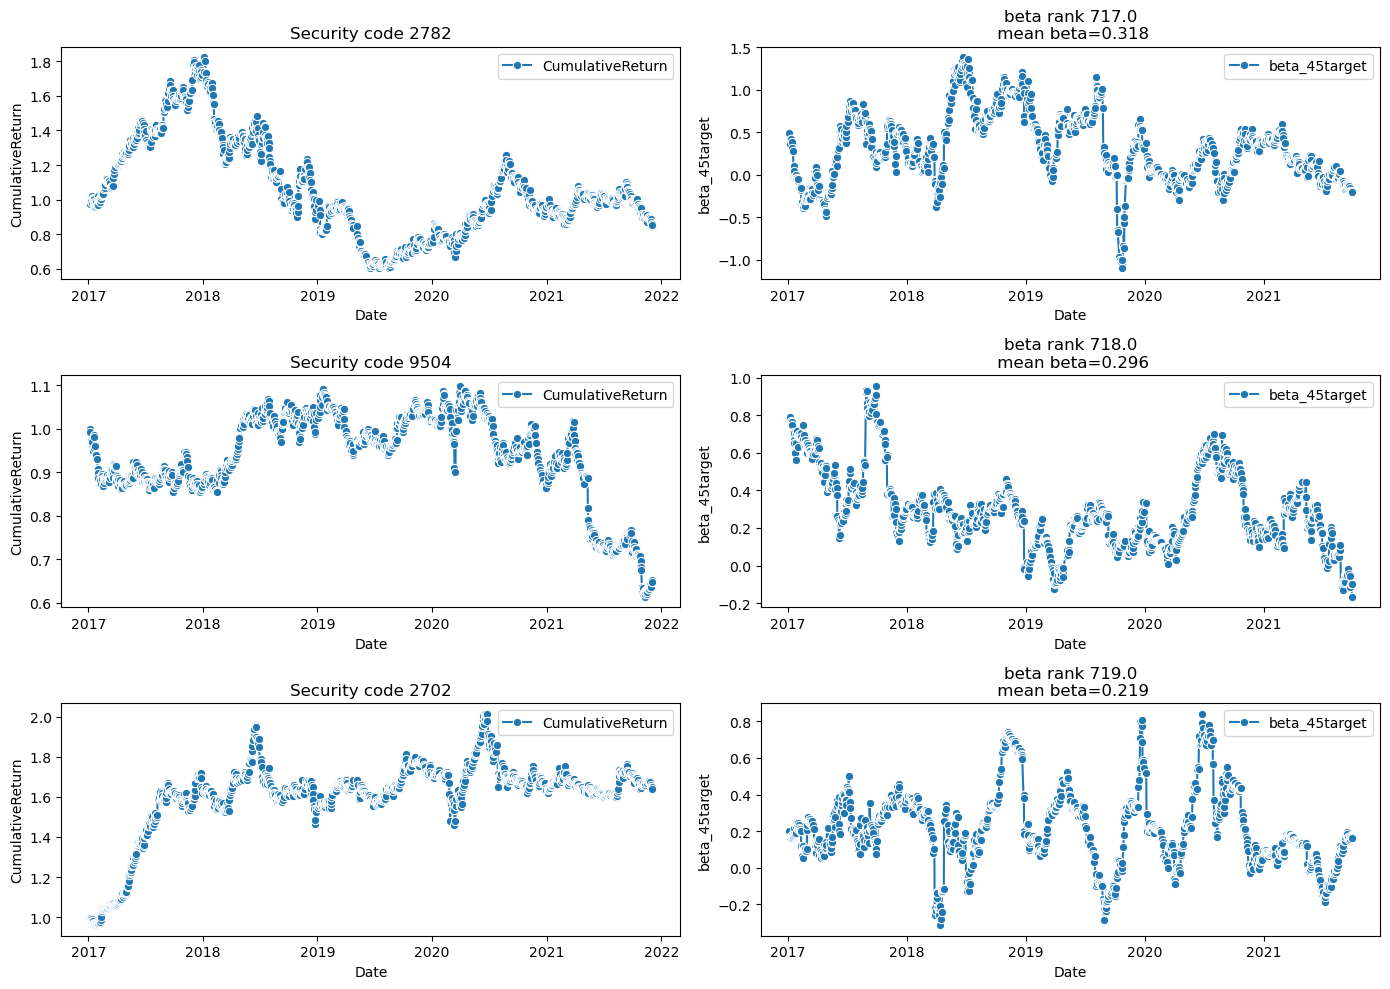

In [31]:
plot_target_timeseries(bottom3_betas, features=['CumulativeReturn'], targets=['beta_45target'])

<font size = 4>

* Seems a little strange that low beta stocks have outperformed some mid tier beta stocks (i.e. security 9539 in the bottom tier has outperformed 4997 in the mid tier).  But this is just few particular examples so it seems possible. 
* There seems to be no evidence that $\beta$ was incorrectly computed so I will continue with feature engineering.

# Baseline forecasts; Target differencing

In [32]:
def training_dataset(data: pd.DataFrame, feature_list: list, target: str, holdout_year: int, market_index=1320):
    df = data[feature_list+[target]].dropna().drop(market_index)
    X_data = df.loc[idx[:, :str(holdout_year-1)], feature_list].copy()
    y_data = df.loc[idx[:, :str(holdout_year-1)], target].copy()
    X_holdout = df.loc[idx[:, str(holdout_year)], feature_list].copy()
    y_holdout = df.loc[idx[:, str(holdout_year)], target].copy()

    return X_data, y_data, X_holdout, y_holdout

## The naive forecast

In [33]:
import statsmodels.api as sm

X_naive, y_baseline, X_naive_holdout, y_holdout = training_dataset(train, feature_list=['beta_45avg'], target='beta_45target', holdout_year=2021)
X_naive = sm.add_constant(X_naive)
X_naive_holdout = sm.add_constant(X_naive_holdout)

naive_model = sm.OLS(y_baseline, X_naive).fit()
print(naive_model.summary())

train_predictions_baseline = pd.DataFrame(index=X_naive.index)
train_predictions_baseline['actual'] = y_baseline
train_predictions_baseline['naive_prediction'] = naive_model.predict(X_naive)
train_predictions_baseline['naive_residual'] = train_predictions_baseline['actual'] - train_predictions_baseline['naive_prediction']


holdout_predictions_baseline = pd.DataFrame(index=X_naive_holdout.index)
holdout_predictions_baseline['actual'] = y_holdout
holdout_predictions_baseline['naive_prediction'] = naive_model.predict(X_naive_holdout)
holdout_predictions_baseline['naive_residual'] = holdout_predictions_baseline['actual'] - holdout_predictions_baseline['naive_prediction']

                            OLS Regression Results                            
Dep. Variable:          beta_45target   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                 1.832e+05
Date:                Tue, 08 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:21:19   Log-Likelihood:            -2.8616e+05
No. Observations:              667740   AIC:                         5.723e+05
Df Residuals:                  667738   BIC:                         5.723e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4504      0.001    436.957      0.0

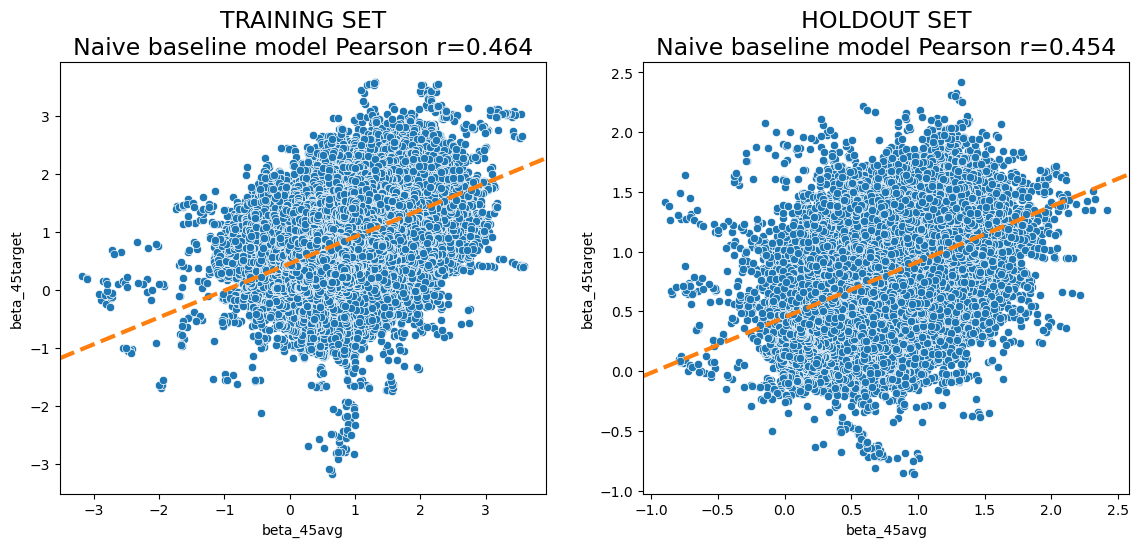

In [34]:
fig, ax = plt.subplots(1, 2, figsize = (9.2*1.5, 5.6))
axa, axb = ax

#AXA
axa.set_title('TRAINING SET\nNaive baseline model Pearson r={:.3g}'.format(naive_model.rsquared**0.5), fontsize=17)
sns.scatterplot(x=X_naive['beta_45avg'], y=y_baseline, ax=axa)

intercept, slope = naive_model.params.values.T
axa.set_xlim(axa.get_xlim())
axa.plot(
    axa.get_xlim(),
    [intercept+slope*i for i in axa.get_xlim()],
    '--', color='tab:orange', linewidth = 3)


#AXB
holdout_naive_pearson = pearsonr(*holdout_predictions_baseline[['actual', 'naive_prediction']].values.T)[0]
axb.set_title('HOLDOUT SET\nNaive baseline model Pearson r={:.3g}'.format(holdout_naive_pearson), fontsize=17)
sns.scatterplot(x=X_naive_holdout['beta_45avg'], y=y_holdout, ax=axb)

axb.set_xlim(axb.get_xlim())
axb.plot(
    axb.get_xlim(),
    [intercept+slope*i for i in axb.get_xlim()],
    '--', color='tab:orange', linewidth = 3)

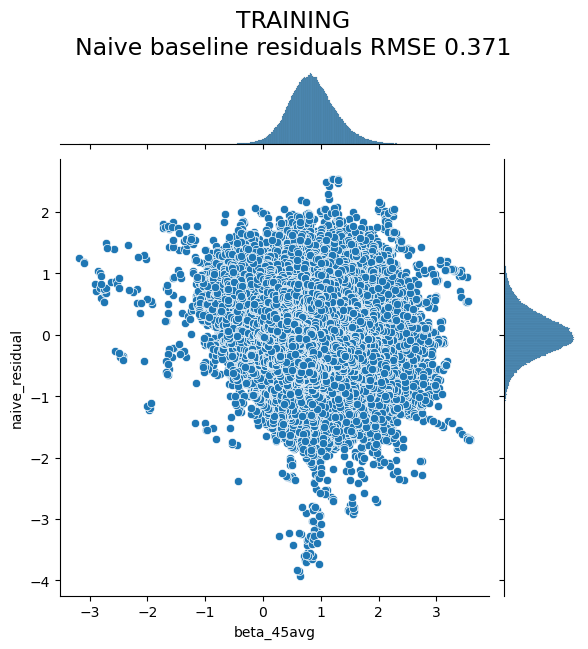

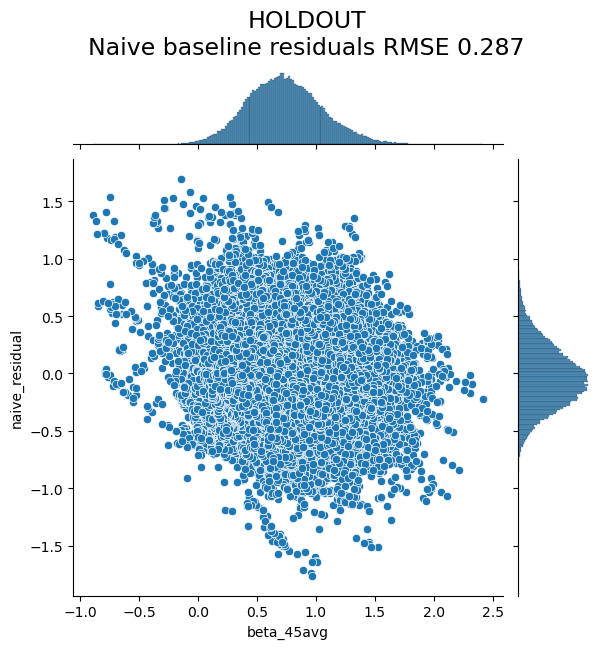

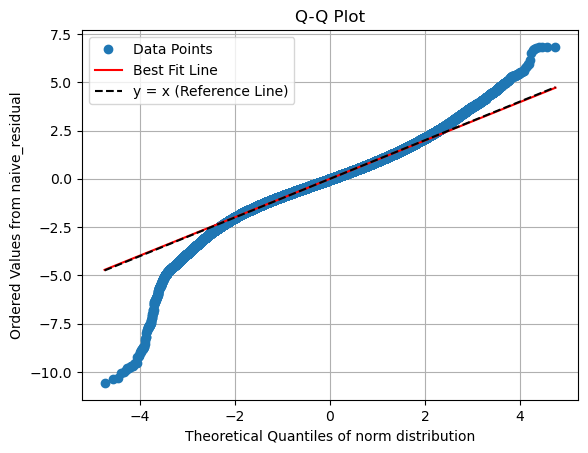

In [35]:
j_train = sns.jointplot(x=X_naive['beta_45avg'], y=train_predictions_baseline['naive_residual'])
plt.suptitle('TRAINING\nNaive baseline residuals RMSE {:.3g}'.format(naive_model.mse_resid**0.5), y=1.075, fontsize = 17)

holdout_naive_rmse = mean_squared_error(*holdout_predictions_baseline[['actual', 'naive_prediction']].values.T, squared=False)
j_holdout = sns.jointplot(x=X_naive_holdout['beta_45avg'], y=holdout_predictions_baseline['naive_residual'])
plt.suptitle('HOLDOUT\nNaive baseline residuals RMSE {:.3g}'.format(holdout_naive_rmse), y=1.075, fontsize = 17)

plot_qq(train_predictions_baseline['naive_residual'])

## The exponentially weighted moving average (EWMA) forecast

### Optimizing the decay paramter

In [36]:
from joblib import Parallel, delayed

def ewm_rolling_beta(df: pd.DataFrame, column, ewm_alpha, min_periods, market_df):
    Y_series = df[column]
    X_series = market_df[column]
    XY_series = X_series * Y_series
    ewm_params = {'alpha': ewm_alpha, 'min_periods': min_periods}
    XY_mean = XY_series.ewm(**ewm_params).mean()
    X_mean = X_series.ewm(**ewm_params).mean()
    Y_mean = Y_series.ewm(**ewm_params).mean()
    X_variance = X_series.ewm(alpha=ewm_alpha).var()
    return (XY_mean - X_mean * Y_mean) / X_variance

# Grid search function for a single alpha value
def grid_search_alpha(alpha, train, market_df, left_threshold):
    result = {}
    
    # Compute beta_ewma using the rolling beta function
    train['beta_ewma'] = train.groupby('Code', group_keys=False).apply(ewm_rolling_beta, 'WinsorReturn', alpha, 45, market_df)
    
    # Transform beta_ewma using the Johnson SU transform function
    # train['beta_ewma_jsunorm'], jsu_params_ewma = johnson_su_transform(train['beta_ewma'])
    # train['beta_ewma_norm'] = tail_specific_transform(train['beta_ewma_jsunorm'], left_threshold=left_threshold)
    
    # Ensure that the holdout set isn't being used to optimize the hyperparameter
    X_ewma, y_baseline, X_ewma_holdout, y_holdout = training_dataset(train, feature_list=['beta_ewma'], target='beta_45target', holdout_year=2021)
    
    # Drop the holdout data
    del X_ewma_holdout, y_holdout
    
    # OLS Training
    X_ewma = sm.add_constant(X_ewma)
    ewma_model = sm.OLS(y_baseline, X_ewma).fit()
    train_predictions = ewma_model.predict(X_ewma)
    
    # Metrics
    rmse_train = mean_squared_error(y_baseline, train_predictions, squared=False)
    mae_train = mean_absolute_error(y_baseline, train_predictions)
    pearson_train = pearsonr(y_baseline, train_predictions)[0]
    spearman_train = spearmanr(y_baseline, train_predictions)[0]
    
    # Store Results
    result = {
        'alpha': alpha,
        'rmse_train': rmse_train,
        'mae_train': mae_train,
        'pearson_train': pearson_train,
        'spearman_train': spearman_train
    }
    
    return result

# Define a range of alpha values for the grid search
alpha_values = np.logspace(-3, np.log10(0.9), 10)
alpha_values = np.sort(np.append(
    alpha_values, 
    np.logspace(np.log10(9e-3), np.log10(3e-2), 10)))

# Parallelize the grid search
n_jobs = -1  # Use all available cores, you can set this to a specific number
left_threshold = -2  # Adjust as needed
results = Parallel(n_jobs=n_jobs)(
    delayed(grid_search_alpha)(alpha, train.copy(), market_df, left_threshold) for alpha in alpha_values)

# Convert results to DataFrame for easy visualization and analysis
results_df = pd.DataFrame(results)


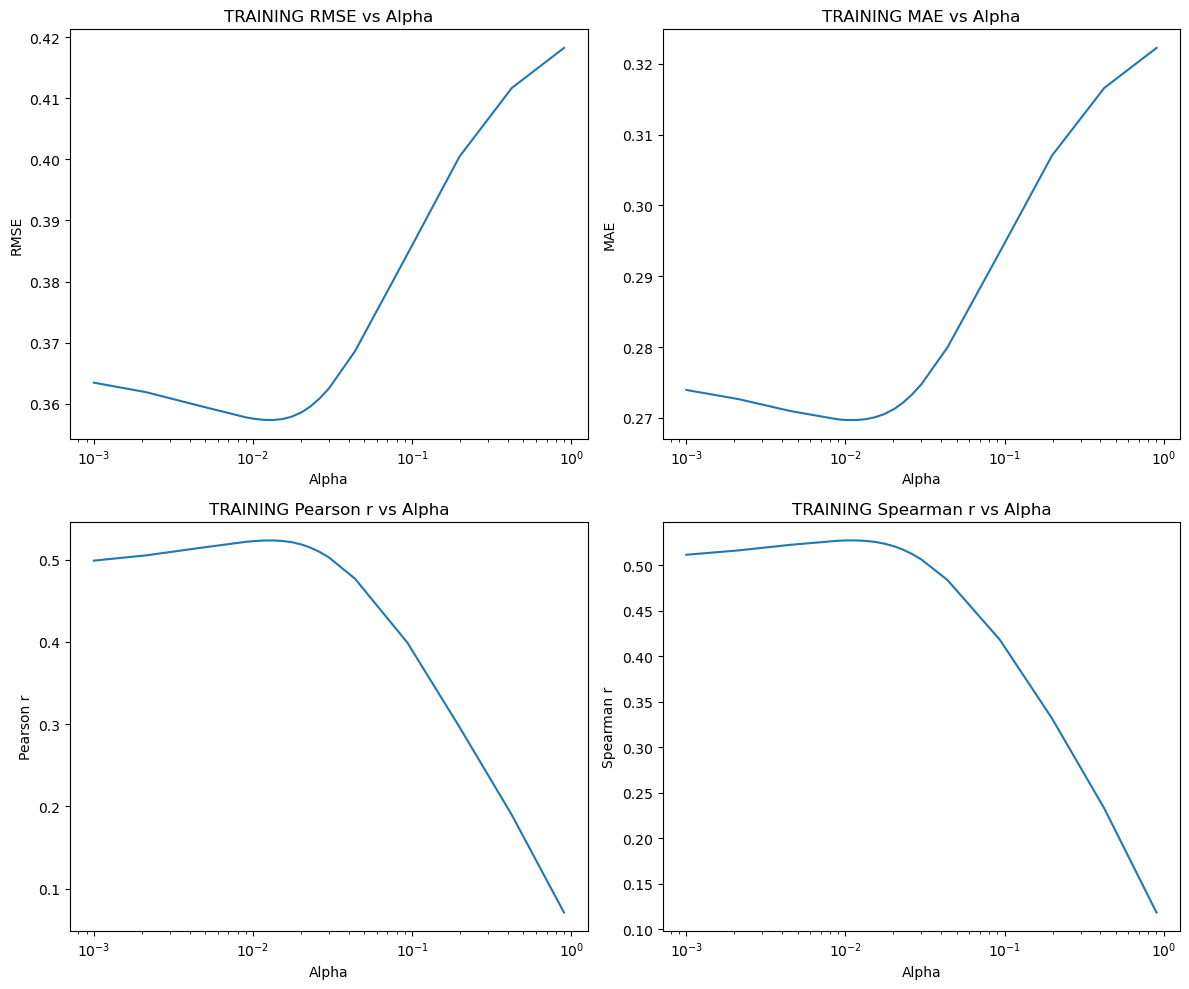

In [37]:
# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

# RMSE vs Alpha
sns.lineplot(x='alpha', y='rmse_train', data=results_df, ax=axes[0])
axes[0].set_title('TRAINING RMSE vs Alpha')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('RMSE')

# MAE vs Alpha
sns.lineplot(x='alpha', y='mae_train', data=results_df, ax=axes[1])
axes[1].set_title('TRAINING MAE vs Alpha')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('MAE')

# Pearson r vs Alpha
sns.lineplot(x='alpha', y='pearson_train', data=results_df, ax=axes[2])
axes[2].set_title('TRAINING Pearson r vs Alpha')
axes[2].set_xlabel('Alpha')
axes[2].set_ylabel('Pearson r')

# Spearman r vs Alpha
sns.lineplot(x='alpha', y='spearman_train', data=results_df, ax=axes[3])
axes[3].set_title('TRAINING Spearman r vs Alpha')
axes[3].set_xlabel('Alpha')
axes[3].set_ylabel('Spearman r')

for ax in axes: ax.set_xscale('log')

plt.tight_layout()
plt.show()


In [38]:
optimal_decay_rate = results_df.set_index('alpha')['rmse_train'].nsmallest(1).index[0]
print('Optimal decay rate is', optimal_decay_rate)
train['beta_ewma'] = train.groupby('Code', group_keys=False).apply(ewm_rolling_beta, 'WinsorReturn', optimal_decay_rate, 45, market_df)
# train['beta_ewma_jsunorm'], jsu_params_ewma = johnson_su_transform(train['beta_ewma'])
# # train['beta_ewma_norm'] = tail_specific_transform(train['beta_ewma_jsunorm'], left_threshold=left_threshold)
# train['beta_ewma_norm'] = train['beta_ewma_jsunorm']
# train['beta_ewma_norm'] = train['beta_ewma_jsunorm']

Optimal decay rate is 0.013444214239671489


In [39]:
X_ewma, y_baseline, X_ewma_holdout, y_holdout = training_dataset(train, feature_list=['beta_ewma'], target='beta_45target', holdout_year=2021)
X_ewma = sm.add_constant(X_ewma)
X_ewma_holdout = sm.add_constant(X_ewma_holdout)

ewma_model = sm.OLS(y_baseline, X_ewma).fit()
print(ewma_model.summary())


train_predictions_baseline['ewma_prediction'] = ewma_model.predict(X_ewma)
train_predictions_baseline['ewma_residual'] = train_predictions_baseline['actual'] - train_predictions_baseline['ewma_prediction']

holdout_predictions_baseline['ewma_prediction'] = ewma_model.predict(X_ewma_holdout)
holdout_predictions_baseline['ewma_residual'] = holdout_predictions_baseline['actual'] - holdout_predictions_baseline['ewma_prediction']

                            OLS Regression Results                            
Dep. Variable:          beta_45target   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                 2.517e+05
Date:                Tue, 08 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:21:37   Log-Likelihood:            -2.6031e+05
No. Observations:              667740   AIC:                         5.206e+05
Df Residuals:                  667738   BIC:                         5.206e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2645      0.001    213.332      0.0

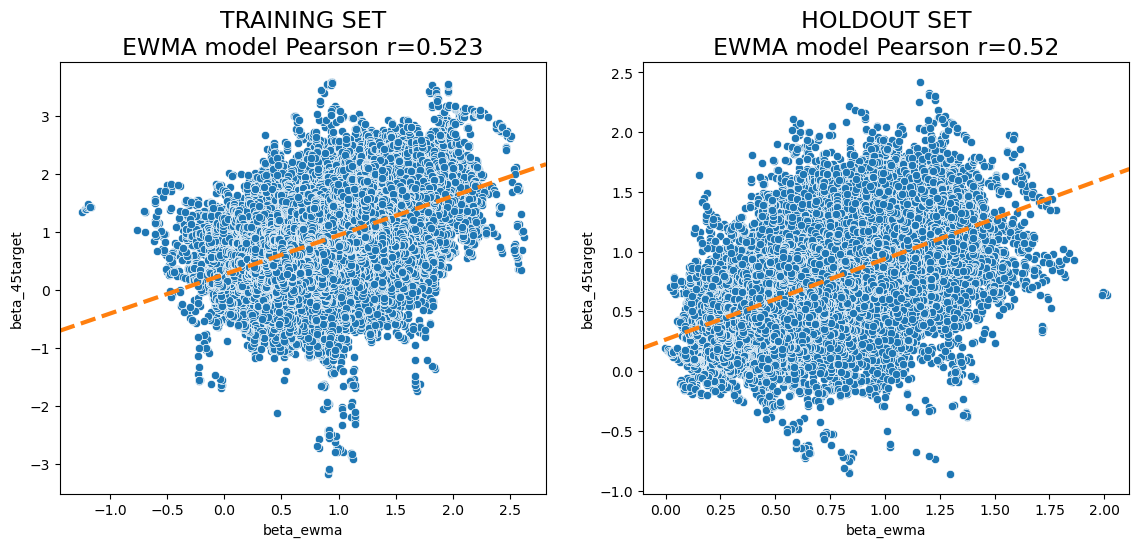

In [40]:
fig, ax = plt.subplots(1, 2, figsize = (9.2*1.5, 5.6))
axa, axb = ax

#AXA
training_ewma_pearson = pearsonr(*train_predictions_baseline[['actual', 'ewma_prediction']].values.T)[0]
axa.set_title('TRAINING SET\nEWMA model Pearson r={:.3g}'.format(training_ewma_pearson), fontsize=17)
sns.scatterplot(x=X_ewma['beta_ewma'], y=y_baseline, ax=axa)

intercept, slope = ewma_model.params.values.T
axa.set_xlim(axa.get_xlim())
axa.plot(
    axa.get_xlim(),
    [intercept+slope*i for i in axa.get_xlim()],
    '--', color='tab:orange', linewidth = 3)


#AXB
holdout_ewma_pearson = pearsonr(*holdout_predictions_baseline[['actual', 'ewma_prediction']].values.T)[0]
axb.set_title('HOLDOUT SET\nEWMA model Pearson r={:.3g}'.format(holdout_ewma_pearson), fontsize=17)
sns.scatterplot(x=X_ewma_holdout['beta_ewma'], y=y_holdout, ax=axb)

axb.set_xlim(axb.get_xlim())
axb.plot(
    axb.get_xlim(),
    [intercept+slope*i for i in axb.get_xlim()],
    '--', color='tab:orange', linewidth = 3)

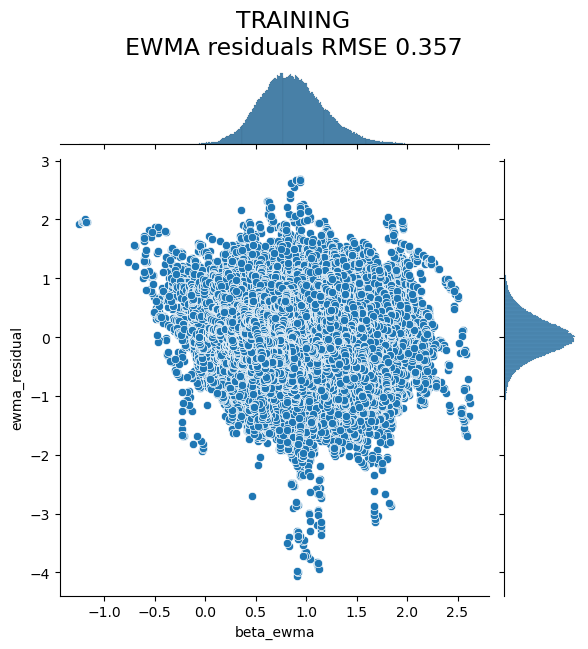

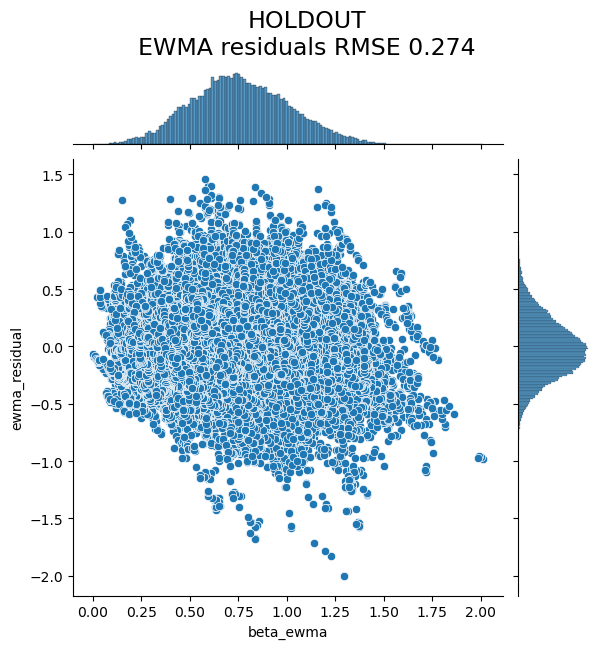

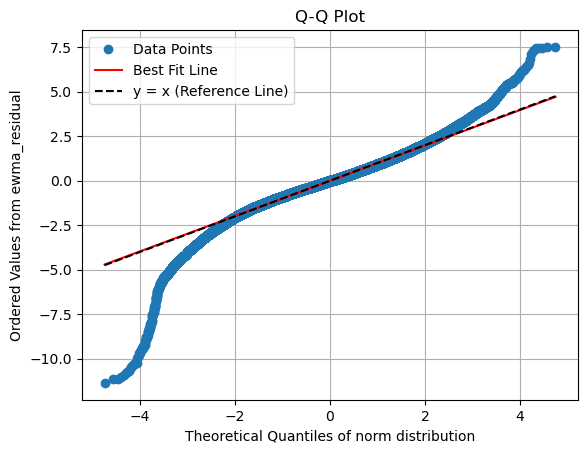

In [41]:
j_train = sns.jointplot(x=X_ewma['beta_ewma'], y=train_predictions_baseline['ewma_residual'])
plt.suptitle('TRAINING\nEWMA residuals RMSE {:.3g}'.format(ewma_model.mse_resid**0.5), y=1.075, fontsize = 17)

holdout_ewma_rmse = mean_squared_error(*holdout_predictions_baseline[['actual', 'ewma_prediction']].values.T, squared=False)
j_holdout = sns.jointplot(x=X_ewma_holdout['beta_ewma'], y=holdout_predictions_baseline['ewma_residual'])
plt.suptitle('HOLDOUT\nEWMA residuals RMSE {:.3g}'.format(holdout_ewma_rmse), y=1.075, fontsize = 17)

plot_qq(train_predictions_baseline['ewma_residual'])

## Correlation between beta EWMA and $\beta$ SMA

Text(0.5, 1.0, 'The pearson correlation between the two features is\nr=0.856')

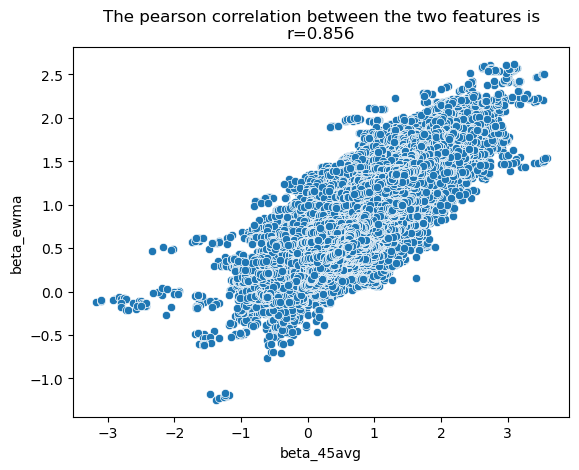

In [42]:
fig, ax = plt.subplots()

sns.scatterplot(train, x='beta_45avg', y='beta_ewma')
ewma_sma_correlation = pearsonr(*train[['beta_45avg', 'beta_ewma']].dropna().values.T)[0]
ax.set_title('The pearson correlation between the two features is\nr={:.3g}'.format(ewma_sma_correlation))

## Baseline model evaluation
<font size=5>

* Since both baseline features are highly correlated, I'll just choose the naive model as my baseline.

 Modeling plan:
* I'll use EWMA model predictions to subtract from my target.
* The RMSE to beat is 0.297, from the naive baseline's performance on the holdout set.

# Feature engineering


* price features
    * standard deviation in returns
    * Bollinger band feature
    * ratio of return to market avg returns
    * average true range 
    * other candle features
    

* Implied volatility of atm options

**I would doubt any feature that had a correlation larger than 0.4 (in absolute magnitude) with the $\beta$ 45 days from now**

If the target has weak correlation with its lagged series, then it seems tough to find a feature that could do better.

In [48]:
TARGET_COL = 'beta_45target'

In [49]:

# Feature calculation functions

def pandas_winsor(series, limit = 1-0.99):
    return pd.Series(winsorize(series, limits = limit).data, index =series.index)


# Plotting methods

def feature_timeseries_plot(tickers:list, feature, target, df:pd.DataFrame = None):
    if df == None: df = train

    fig, ax = plt.subplots(2, len(tickers), figsize = (14, 10))

    for i , tick in enumerate(tickers):
        ax[0, i].set_title('Security code {:}'.format(tick))
        ax[1, i].set_title('beta rank {:}'.format(universe_stats.loc[tick, 'beta_rank']))        
        sns.lineplot(df.loc[tick], x= 'Date', y = target, ax = ax[0, i])
        sns.lineplot(df.loc[tick], x= 'Date', y = feature, ax = ax[1, i])
    return

# def beta_feature_scatter(feature, spearman = False, df:pd.DataFrame = None,):
#     '''
#     2 scatter plots of the beta and beta differences vs. the feature
#     '''
#     fig, ax = plt.subplots(ncols= 2, figsize = (9.2*1.5,5.6))
#     feature_scatter(feature, 'beta_target_45', spearman, df, fig =fig, ax = ax[0])

def feature_scatter(feature, target, spearman=False, df:pd.DataFrame=None, fig =None, ax = None):

    if df ==None:
        df = train.loc[train.index.get_level_values(0)!=1320]
    if ax ==None:
        fig, ax = plt.subplots()
    df=df[[feature, target]].dropna()
    sns.scatterplot(data = df, x = feature, y = target, ax = ax)

    pearson_r = pearsonr(df[feature], df[target])[0]
    print(f'{target} vs {feature} pearson r={pearson_r}')
    ax.set_title('{:} has pearson r of {:.3g}'.format(feature, pearson_r))

    if spearman:
        spearman_r = spearmanr(df[feature], df[target])[0]
        print(f'{target} vs {feature} spearman r={spearman_r}')
    
def feature_heatmap(feat_list:list,targets:list = None, data:pd.DataFrame =None, ):
    '''
    Plots a heat map of the correaltion matrix
    ''' 
    n_feats = len(feat_list)
    fig, ax = plt.subplots(figsize = (1.5 * n_feats, 1.5*n_feats))

    if data == None: data = train
    if targets == None: targets = ['beta_target_45']
    cols = feat_list + targets
    sns.heatmap(data[cols].dropna().corr(), ax = ax, cmap = 'viridis',annot=True, fmt = '.2g')
    

## Lagged target features

In [76]:
average_feat_windows = [5, 15, 30]

for window in average_feat_windows:
    train[f'beta_45avg_sma{window}'] = train['beta_45avg'].groupby('Code', group_keys=False).rolling(window).mean().droplevel(0)
    train[f'beta_45avg_std{window}'] = train['beta_45avg'].groupby('Code', group_keys=False).rolling(window).std().droplevel(0)
    train[f'beta_45avg_ewma{window}'] = train['beta_45avg'].groupby('Code', group_keys=False).ewm(span=window).mean().droplevel(0)
    train[f'beta_45avg_ewma_std{window}'] = train['beta_45avg'].groupby('Code', group_keys=False).ewm(span=window).std().droplevel(0)


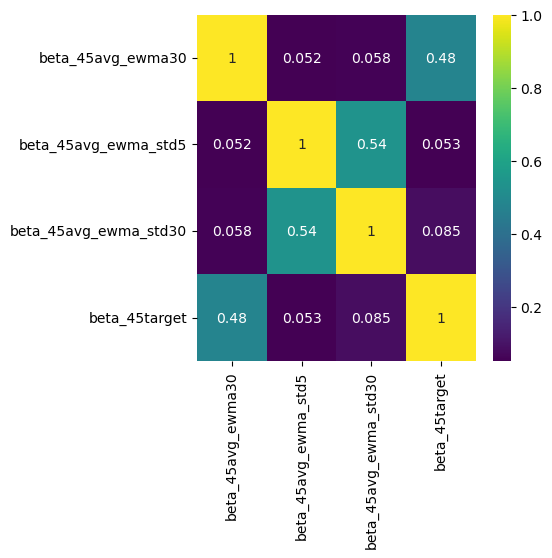

In [87]:
# feature_heatmap([f'beta_45avg_sma{i}' for i in average_feat_windows], targets=[TARGET_COL])
# feature_heatmap([f'beta_45avg_std{i}' for i in average_feat_windows], targets=[TARGET_COL])
# feature_heatmap([f'beta_45avg_ewma{i}' for i in average_feat_windows], targets=[TARGET_COL])
# feature_heatmap([f'beta_45avg_ewma_std{i}' for i in average_feat_windows], targets=[TARGET_COL])

moving_statistic_features = [
    # 'beta_45avg_sma5', 
    # 'beta_45avg_std5', 'beta_45avg_std30', 
    'beta_45avg_ewma30', 
    'beta_45avg_ewma_std5', 'beta_45avg_ewma_std30']

feature_heatmap(moving_statistic_features, targets=[TARGET_COL])

### Beta momentum feature

In [132]:
# train['beta_20avg'] = train.groupby('Code', group_keys=False).apply(rolling_beta, 20, 'WinsorReturn')
# train['beta_20ewma'] = train.groupby('Code', group_keys=False).apply(ewm_rolling_beta, 'WinsorReturn', 2/(20+1), 45, market_df)
# train['beta_crossover20'] = train['beta_20avg'] - train['beta_20ewma']

crossover_windows = [5, 10, 15, 20, 25, 30, 35, 40]

for window in crossover_windows:
    # train[f'beta_{window}avg'] = train.groupby('Code', group_keys=False).apply(rolling_beta, window, 'WinsorReturn')
    # train[f'beta_{window}ewma'] = train.groupby('Code', group_keys=False).apply(ewm_rolling_beta, 'WinsorReturn', 2/(window+1), window, market_df)
    train[f'beta_{window}avg'] = train.groupby('Code', group_keys=False)['beta_45avg'].rolling(window).mean().droplevel(0)
    train[f'beta_{window}ewma'] = train.groupby('Code', group_keys=False)['beta_45avg'].ewm(span = window).mean().droplevel(0)
    train[f'beta_crossover{window}'] = train[f'beta_{window}avg'] - train[f'beta_{window}ewma']

crossover_features = [f'beta_crossover{i}' for i in crossover_windows]

In [133]:
train['beta_macd1525'] = train['beta_15ewma'] - train['beta_25ewma']
train['beta_macd1535'] = train['beta_15ewma'] - train['beta_35ewma']

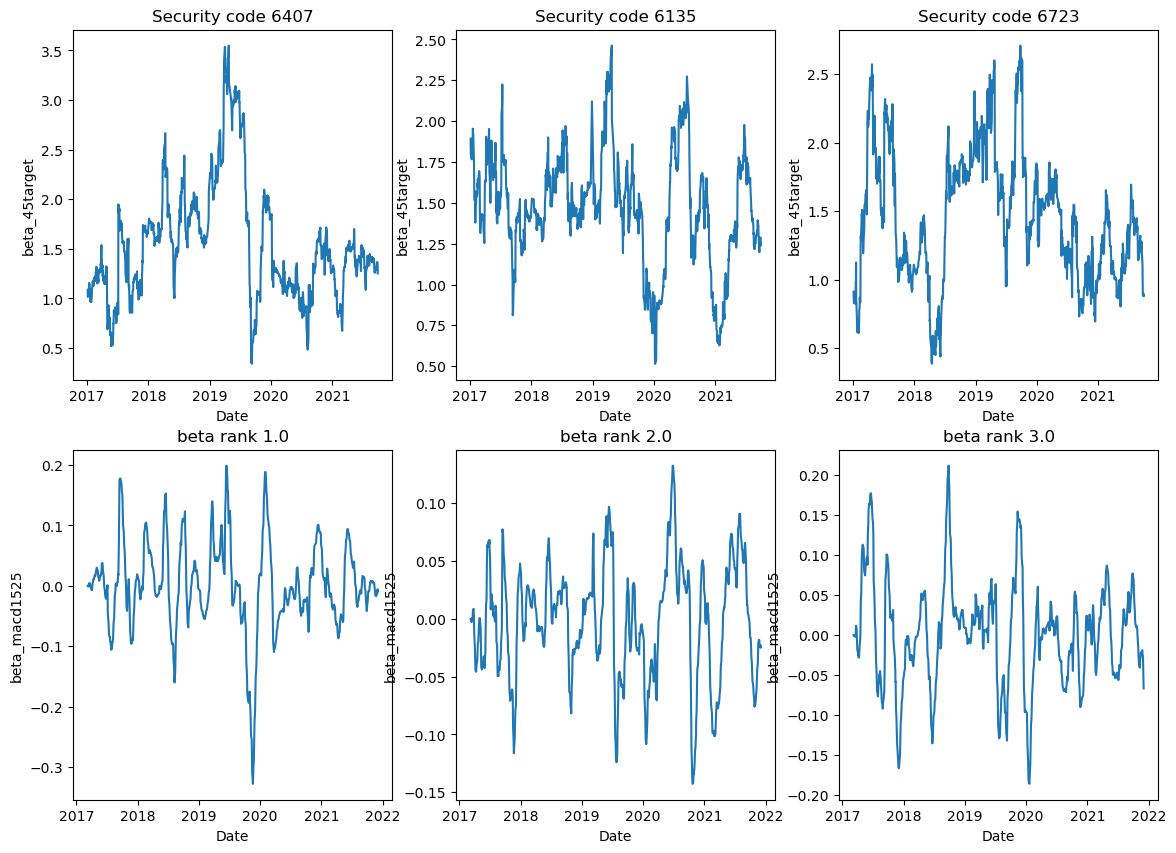

In [136]:
feature_timeseries_plot(top3_betas, feature='beta_macd1525', target='beta_45target')

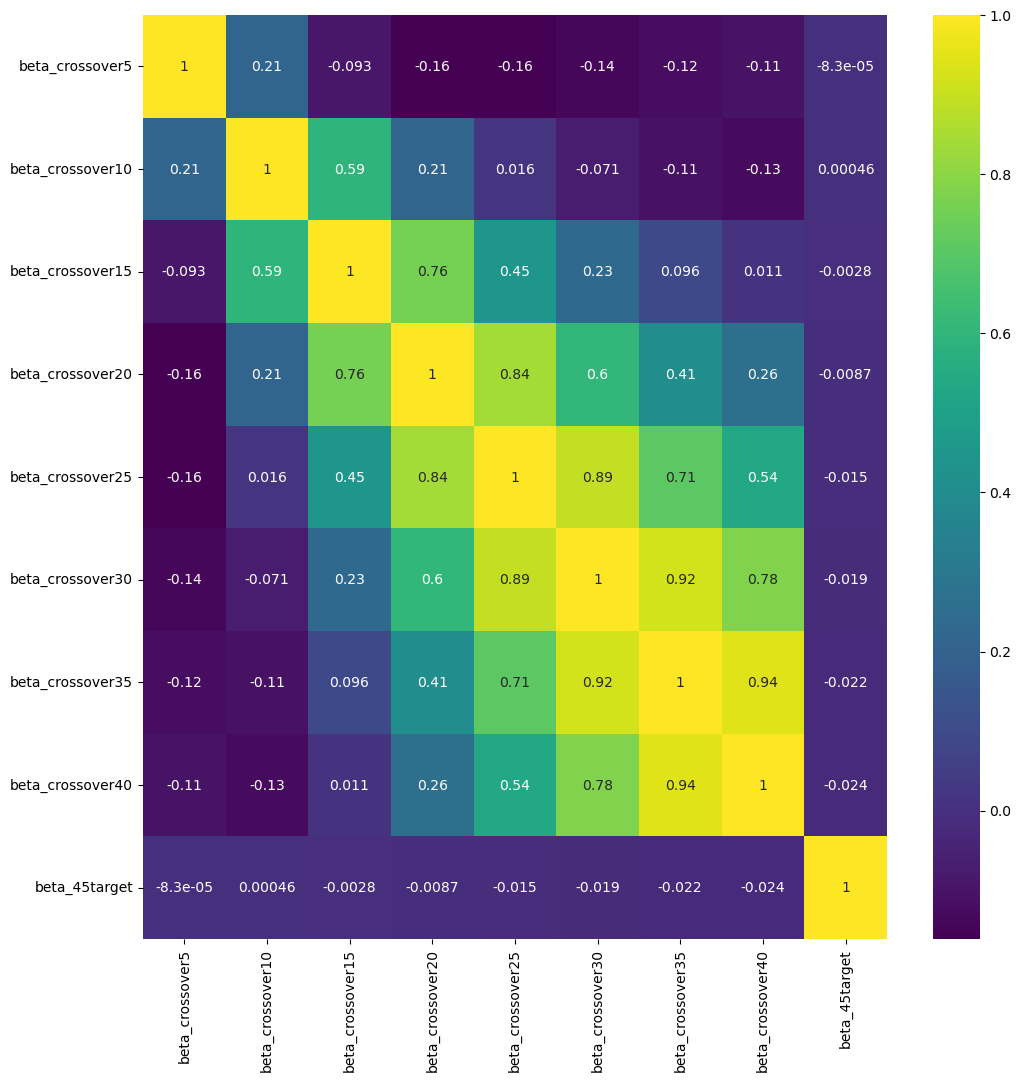

In [135]:
feature_heatmap(crossover_features, targets=[TARGET_COL])

## Symbol/ticker feature

* Work in progress
* I need to encode a categorical feature into a numerical feature to be compatible with linear and ridge regression modules from `sklearn`

In [50]:
# train['symbol'] = train.index.get_level_values('Code').astype(str)
# symbol_dicts = [{str(symbol): 1} for symbol in universe_list]

# from sklearn.feature_extraction import FeatureHasher

# hasher = FeatureHasher(n_features=13, input_type='dict')
# hashed_tickers = hasher.transform(symbol_dicts)

# collision_matrix = np.zeros(shape=hashed_tickers.shape)

# for i, dict in enumerate(symbol_dicts):
#     single_hashed = hasher.transform([dict]).toarray()
#     collision_matrix[i] = single_hashed

# column_sums = np.sum(np.abs(collision_matrix), axis=0)    
# collision_check = np.any(column_sums > 1)

## Volatility
The standard deviation in returns


10 day period

In [52]:
def calc_volatility(_win, series, data:pd.DataFrame =None):
    if data ==None: data = train
    col_name = f'sigma_{_win}'
    data[col_name] = data.groupby('Code', group_keys=False)[series].apply(
        pandas_winsor).groupby('Code').rolling(_win).std().bfill().droplevel(0)
    return data
    # return data[col_name]

feature_window_span = [5, 15, 30, 45]
for w in feature_window_span: 
    calc_volatility(w, 'WinsorReturn')

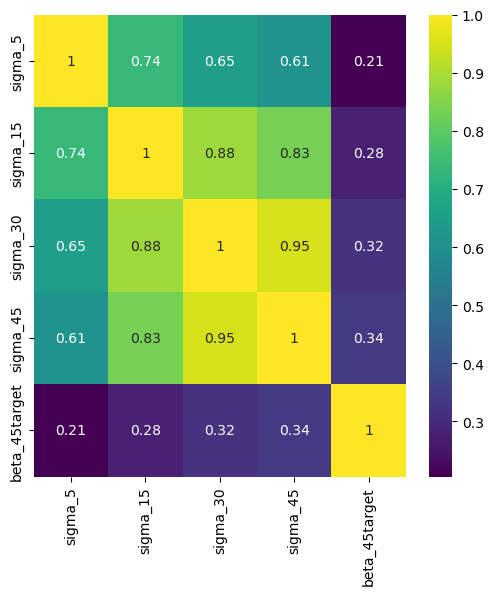

In [53]:
feature_heatmap([f'sigma_{i}' for i in feature_window_span], targets=[TARGET_COL])
# beta_feature_scatter('sigma_45')
# feature_scatter('sigma_45', 'beta_target_45')

* The longer the averaging window of the feature, the stronger the correlation

## Return to spy return ratio

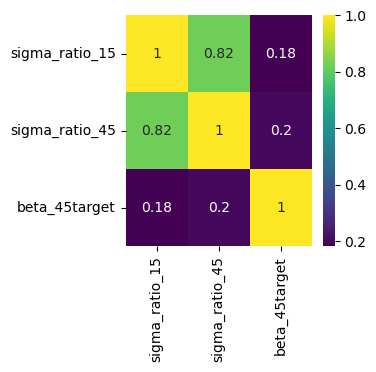

In [54]:
train['sigma_ratio_15'] = train.groupby('Code', group_keys=False)['sigma_15'].apply(
    lambda x: x/train.loc[1320, 'sigma_15'])
train['sigma_ratio_45'] = train.groupby('Code', group_keys=False)['sigma_15'].apply(
    lambda x: x/train.loc[1320, 'sigma_45'])
feature_heatmap([f'sigma_ratio_{i}' for i in [15, 45]], targets=[TARGET_COL])


## Bollinger band feature

In [55]:
def calc_bbands(periods:list, series_col:str, data:pd.DataFrame = None):
    if data == None: data = train
    for p in periods:
        bbmid_col = f'sma_{p}'
        data[bbmid_col] = data.groupby('Code')[series_col].rolling(p).mean().droplevel(0)
        bb_std = data.groupby('Code')[series_col].rolling(p).std().droplevel(0)
        data[f'bbhigh_{p}'] = data[bbmid_col] + 2*bb_std
        data[f'bblow_{p}'] = data[bbmid_col] - 2*bb_std
        data[f'bbceil_{p}'] = 1-data[series_col]/data[f'bbhigh_{p}']
        data[f'bbfloor_{p}'] = 1-data[f'bblow_{p}']/data[series_col]
        # data[f'bbdiff_{p}'] = data[f'bbceil_{p}']+data[f'bbfloor_{p}']

calc_bbands(feature_window_span, 'CumulativeReturn')
train

RowId     Open     High      Low    Close  Volume  \
Code Date                                                                    
1320 2017-01-04  20170104_1320  19790.0  20110.0  19790.0  20110.0   88913   
     2017-01-05  20170105_1320  20120.0  20120.0  19980.0  20040.0  138650   
     2017-01-06  20170106_1320  19860.0  19990.0  19840.0  19970.0   49115   
     2017-01-10  20170110_1320  19930.0  19990.0  19760.0  19800.0  107958   
     2017-01-11  20170111_1320  19860.0  19910.0  19840.0  19860.0   66439   
...                        ...      ...      ...      ...      ...     ...   
9989 2021-11-29  20211129_9989   3070.0   3080.0   3045.0   3055.0  328400   
     2021-11-30  20211130_9989   3020.0   3060.0   2984.0   2989.0  615800   
     2021-12-01  20211201_9989   2955.0   2970.0   2934.0   2937.0  339800   
     2021-12-02  20211202_9989   2910.0   2993.0   2909.0   2947.0  319900   
     2021-12-03  20211203_9989   2969.0   3040.0   2958.0   3015.0  411100   

                 AdjustmentFactor  ExpectedDividend  SupervisionFlag  \
Code Date                                                              
1320 2017-01-04               1.0               NaN            False   
     2017-01-05               1.0               NaN            False   
     2017-01-06               1.0               NaN            False   
     2017-01-10               1.0               NaN            False   
     2017-01-11               1.0               NaN            False   
...                           ...               ...              ...   
9989 2021-11-29               1.0               NaN            False   
     2021-11-30               1.0               NaN            False   
     2021-12-01               1.0               NaN            False   
     2021-12-02               1.0               NaN            False   
     2021-12-03               1.0               NaN            False   

                 CumulativeAdjustmentFactor  ...    sma_30  bbhigh_30  \
Code Date                                    ...                        
1320 2017-01-04                         1.0  ...       NaN        NaN   
     2017-01-05                         1.0  ...       NaN        NaN   
     2017-01-06                         1.0  ...       NaN        NaN   
     2017-01-10                         1.0  ...       NaN        NaN   
     2017-01-11                         1.0  ...       NaN        NaN   
...                                     ...  ...       ...        ...   
9989 2021-11-29                         0.5  ...  0.813063   0.882327   
     2021-11-30                         0.5  ...  0.808387   0.879356   
     2021-12-01                         0.5  ...  0.804103   0.879990   
     2021-12-02                         0.5  ...  0.799902   0.879129   
     2021-12-03                         0.5  ...  0.795848   0.874283   

                 bblow_30  bbceil_30  bbfloor_30    sma_45  bbhigh_45  \
Code Date                                                               
1320 2017-01-04       NaN        NaN         NaN       NaN        NaN   
     2017-01-05       NaN        NaN         NaN       NaN        NaN   
     2017-01-06       NaN        NaN         NaN       NaN        NaN   
     2017-01-10       NaN        NaN         NaN       NaN        NaN   
     2017-01-11       NaN        NaN         NaN       NaN        NaN   
...                   ...        ...         ...       ...        ...   
9989 2021-11-29  0.743799   0.149279    0.009079  0.826181   0.896581   
     2021-11-30  0.737417   0.164845   -0.004111  0.822845   0.896105   
     2021-12-01  0.728216   0.179966   -0.009139  0.819361   0.896617   
     2021-12-02  0.720675   0.176368    0.004701  0.816178   0.897069   
     2021-12-03  0.717413   0.152693    0.031552  0.813776   0.897077   

                 bblow_45  bbceil_45  bbfloor_45  
Code Date                                         
1320 2017-01-04       NaN        NaN         NaN  
     2017-01-05     

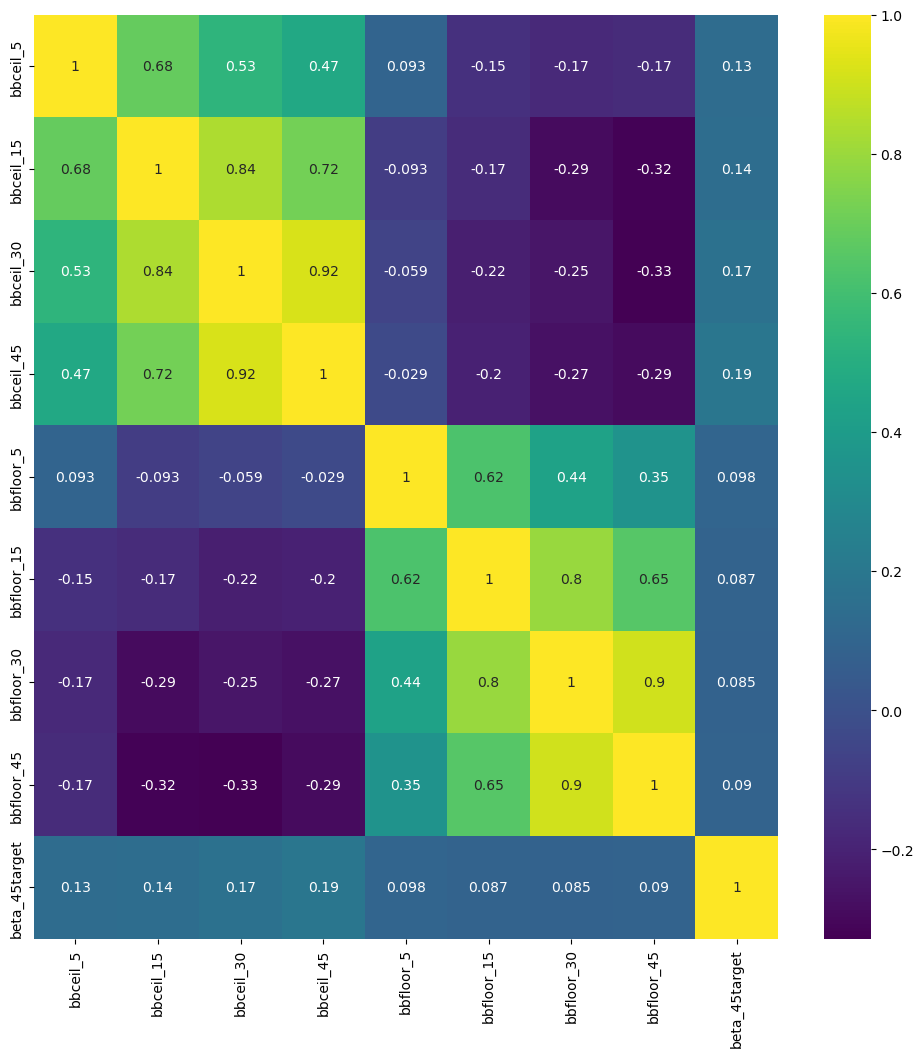

In [56]:
# feature_timeseries_plot(top3_betas, 'bbceil_45', 'beta_target_45')

bb_feats = [f'bbceil_{i}' for i in feature_window_span]+[f'bbfloor_{i}' for i in feature_window_span]#+[f'bbdiff_{i}' for i in feature_window_span]
feature_heatmap(bb_feats, targets = [TARGET_COL])

## ATR features

In [57]:
train['ATR_1'] =train.groupby('Code').apply(lambda x: (1/x['Close'])*(x['High'] - x['Low'])*x['AdjustmentFactor'].cumprod()).droplevel(0)
train['ATR_2'] =train.groupby('Code').apply(lambda x: (1/x['Close'])*(x['High'] - x['Open'])*x['AdjustmentFactor'].cumprod()).droplevel(0)
train['ATR_3'] =train.groupby('Code').apply(lambda x: (1/x['Close'])*(x['Open'] - x['Low'])*x['AdjustmentFactor'].cumprod()).droplevel(0)

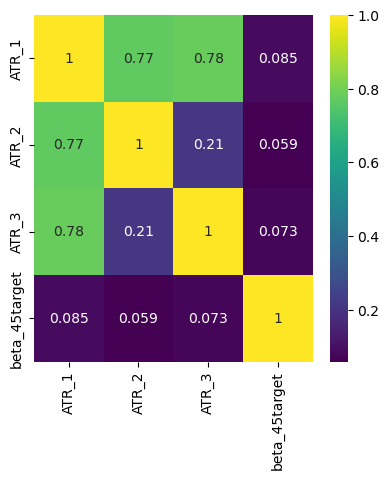

In [58]:
feature_heatmap(['ATR_1', 'ATR_2', 'ATR_3'], targets=[TARGET_COL])

## Design matrix $X$
<font size = 5>

* Split the data into training and holdout set 

In [144]:
train['ticker'] = train.index.get_level_values(0)
train['month'] = train.index.get_level_values(1).month 
train['week'] = train.index.get_level_values(1).isocalendar().week.values
atr_feats = [f'ATR_{i+1}' for i in range(3)]
vol_feats = [f'sigma_{i}' for i in feature_window_span]

# I'll forego cat
# cat_feats = ['ticker', 'month', 'week']
# cat_feats = ['ticker']
cat_feats = []
train[cat_feats] = train[cat_feats].astype('object')

custom_picked_feats = [
    'beta_ewma',
    'beta_45avg',
    # 'DollarVolume',
    'sigma_ratio_15', 'sigma_ratio_45',
    'ATR_2', 'ATR_3',# 'ATR_1', 
    'sigma_15', 'sigma_45',
    'bbceil_15', 'bbceil_45', 
    'beta_crossover40',
    'beta_macd1525',
    ] + moving_statistic_features


# beta_feature_list = atr_feats+vol_feats+bb_feats +cat_feats
beta_feature_list =custom_picked_feats+cat_feats

# target = 'delta_target_norm'


X_ridge, y_ridge, X_holdout, y_holdout = training_dataset(train, feature_list=beta_feature_list, target=TARGET_COL, holdout_year=2021)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

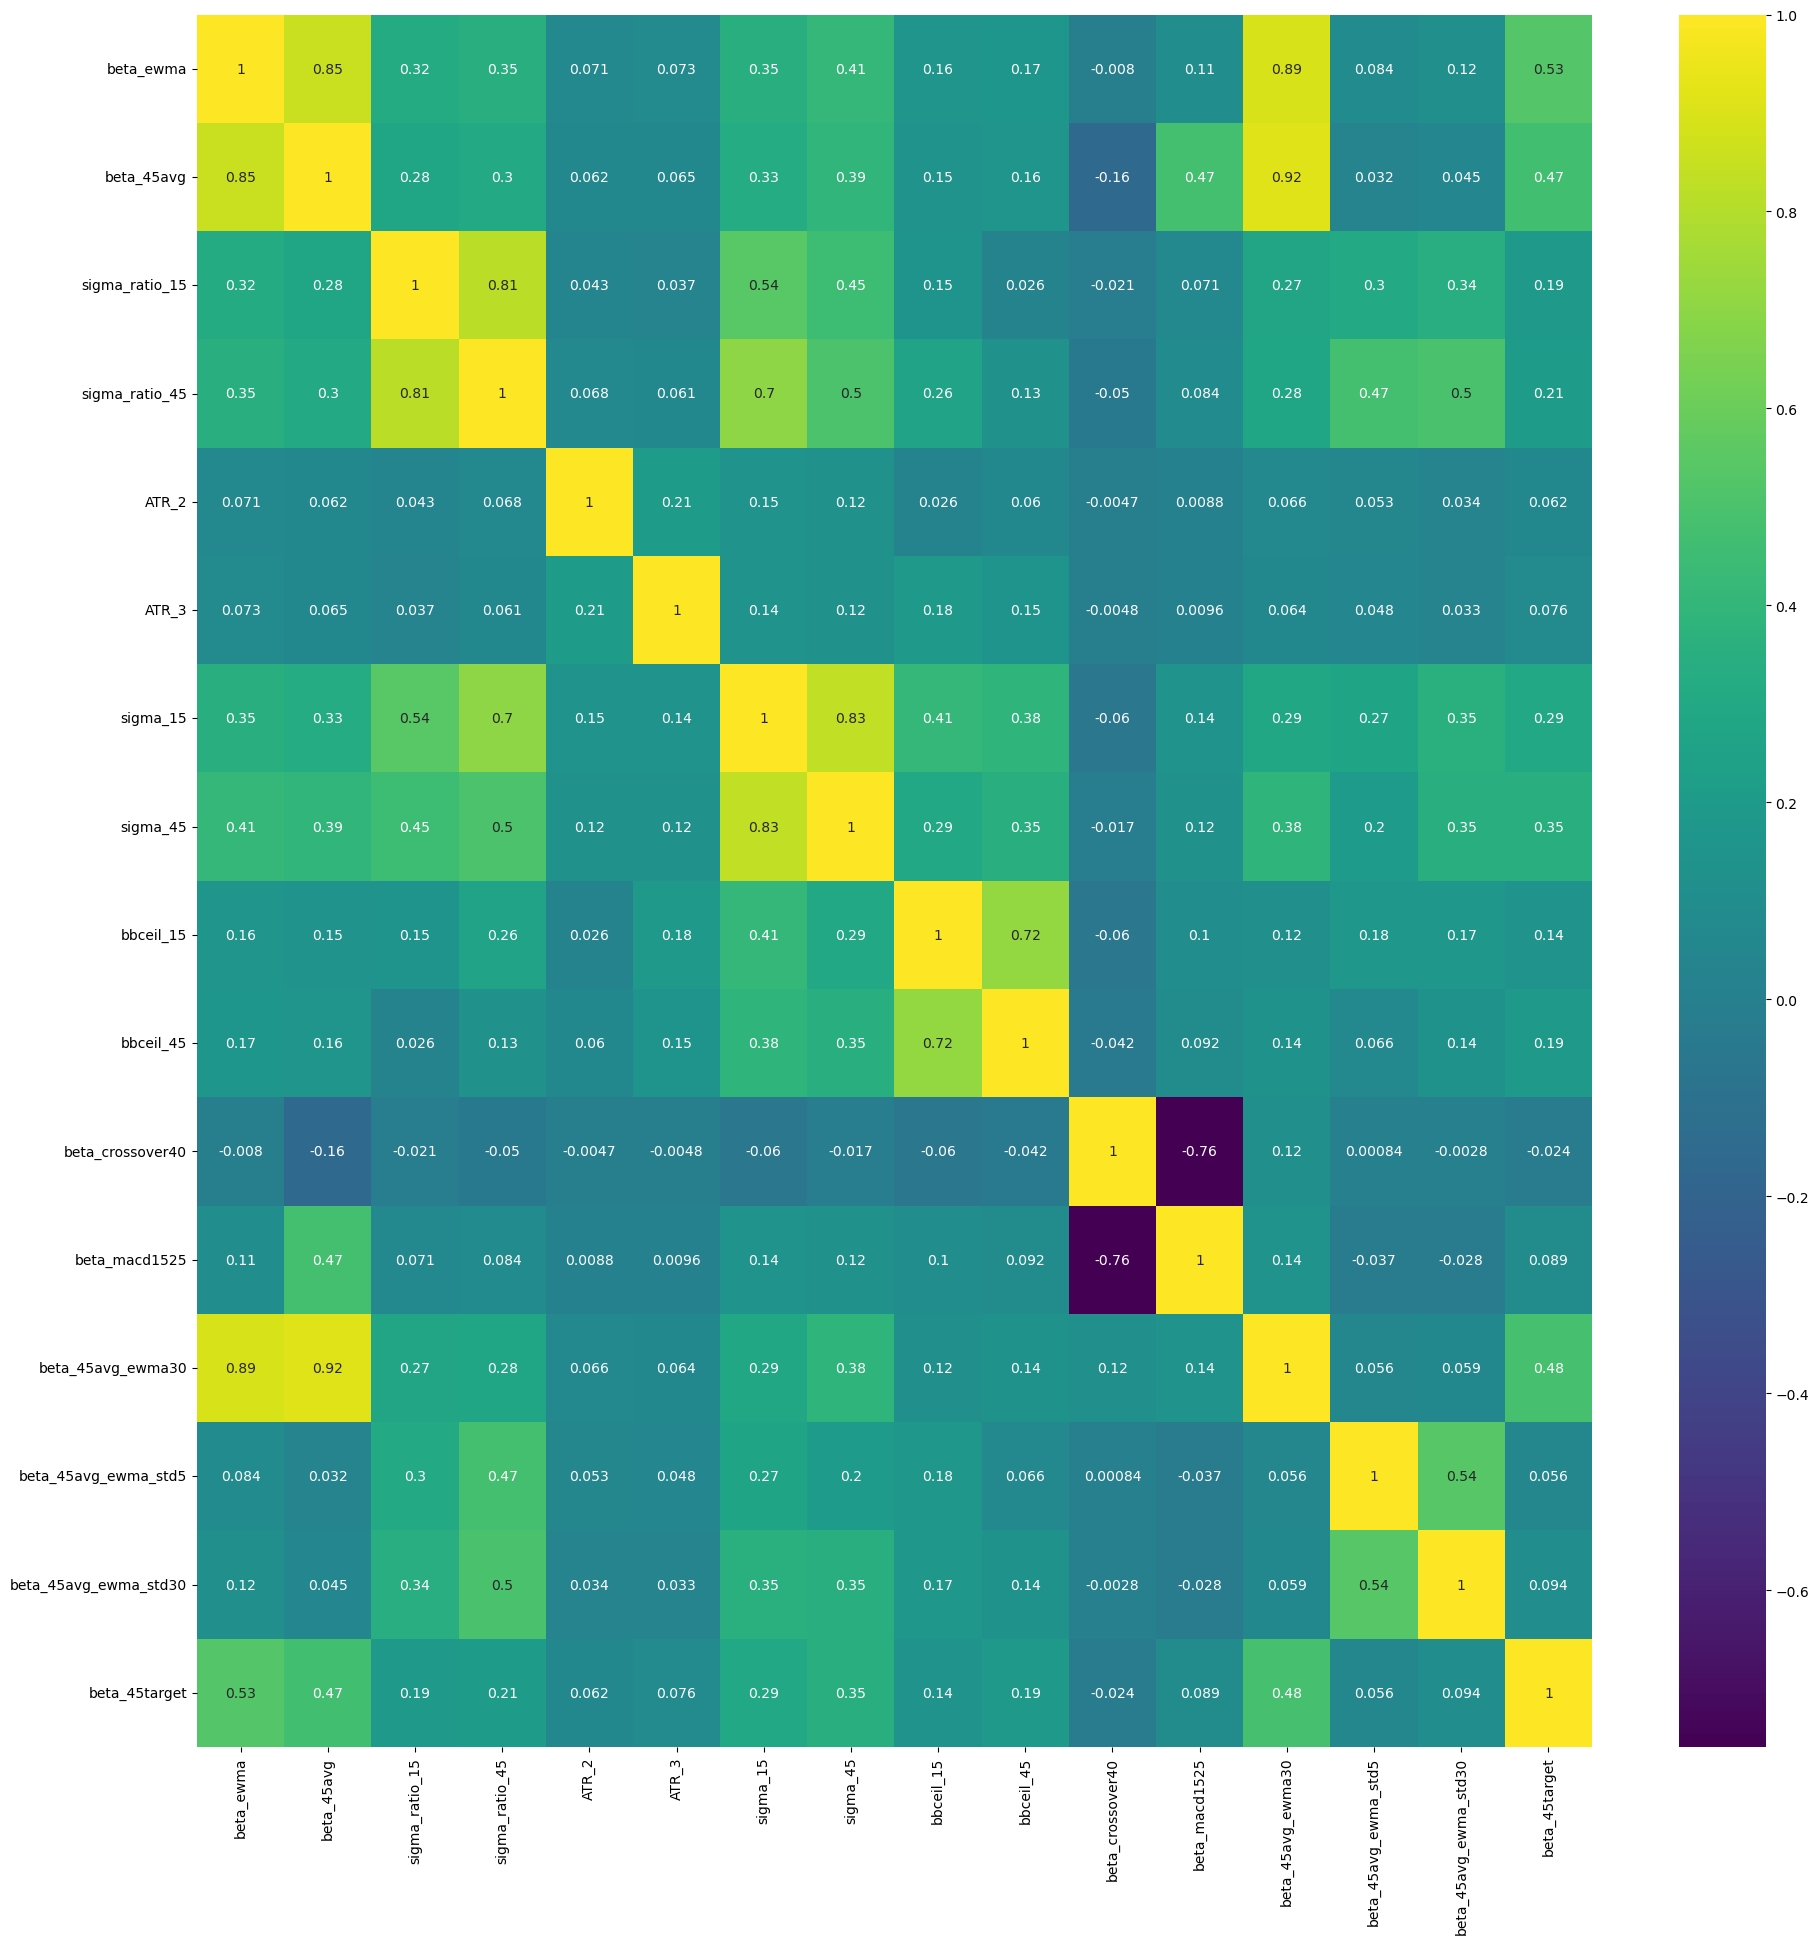

In [145]:
feature_heatmap(beta_feature_list, [TARGET_COL])
plt.tight_layout


## PCA 

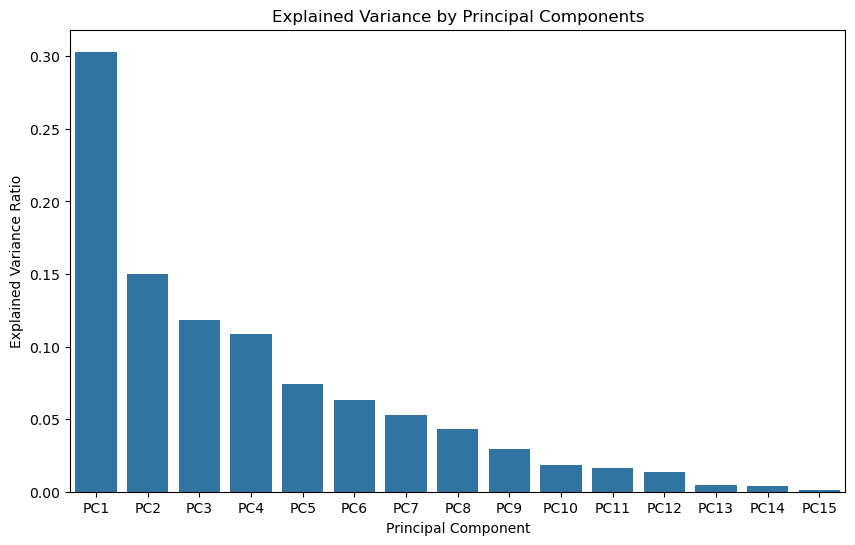

In [146]:
# Create a pipeline that consists of a StandardScaler and PCA
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes the features
    ('pca', PCA(n_components=None))  # Performs PCA
])

# Fit the PCA pipeline to X_ridge
pca_pipeline.fit(X_ridge)

# Get the transformed PCA features
X_pca = pca_pipeline.transform(X_ridge)

# Get the explained variance ratio for each principal component
explained_variance = pca_pipeline.named_steps['pca'].explained_variance_ratio_

# Create a DataFrame for the principal components and their explained variance
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance Ratio': explained_variance
})

# Plot the explained variance ratio for each component
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Principal Component', y='Explained Variance Ratio', data=explained_variance_df, ax=ax)
ax.set_title('Explained Variance by Principal Components')
ax.set_ylabel('Explained Variance Ratio')
ax.set_xlabel('Principal Component')
plt.show()

# Optionally: You can inspect the first few rows of the transformed PCA features
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

In [160]:
X_ridge.shape

(639738, 15)

In [158]:
X_pca.shape

(639738, 15)

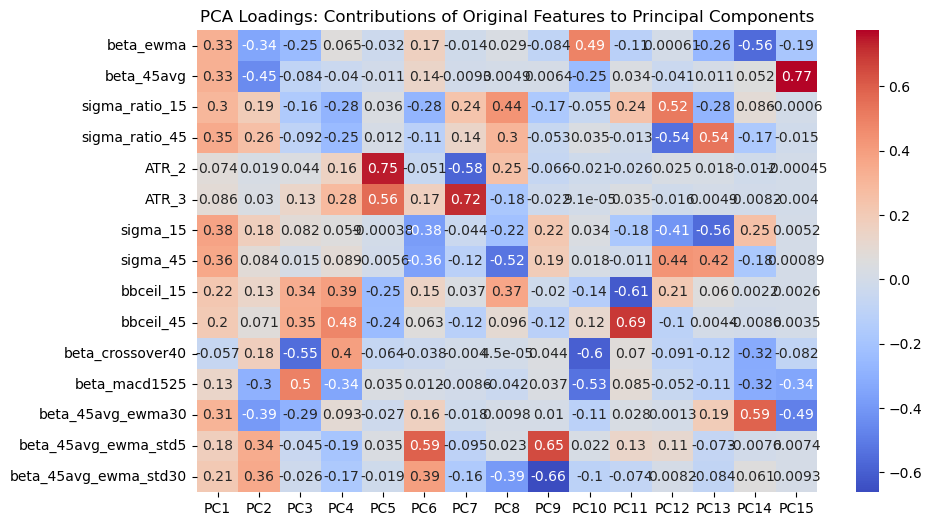

In [153]:
# Get the PCA loadings (the components)
pca_components = pca_pipeline.named_steps['pca'].components_

# Create a DataFrame for the loadings with the PCs as rows and the original features as columns
pca_loadings_df = pd.DataFrame(pca_components, columns=X_ridge.columns, index=[f'PC{i+1}' for i in range(pca_components.shape[0])])

# Display the loadings DataFrame
# print(pca_loadings_df)

# Optionally, visualize the loadings for the first two principal components
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pca_loadings_df.T, annot=True, cmap="coolwarm", ax=ax)
ax.set_title('PCA Loadings: Contributions of Original Features to Principal Components')
plt.show()


                 PC1           PC2           PC3           PC4           PC5  \
PC1     1.000000e+00  8.105096e-16  2.660830e-16  3.842164e-16  4.601241e-16   
PC2     8.105096e-16  1.000000e+00  8.750922e-16 -1.251511e-16 -1.701347e-16   
PC3     2.660830e-16  8.750922e-16  1.000000e+00  8.497093e-16 -3.612175e-16   
PC4     3.842164e-16 -1.251511e-16  8.497093e-16  1.000000e+00 -7.201283e-16   
PC5     4.601241e-16 -1.701347e-16 -3.612175e-16 -7.201283e-16  1.000000e+00   
PC6     3.959580e-16 -1.294158e-16 -1.292680e-16  2.448144e-16  1.070807e-15   
PC7    -8.029969e-18  6.481414e-17  3.320814e-16 -7.467698e-17  7.811675e-17   
PC8     2.507383e-16  1.690331e-16 -1.560069e-16 -6.460598e-16 -2.515205e-16   
PC9     2.735838e-16  1.223021e-17 -5.961654e-17  2.885210e-16  7.074390e-16   
PC10   -1.407285e-16  4.915753e-16  3.794329e-16  4.101302e-16  2.043733e-16   
PC11   -1.352547e-17  2.640166e-16  1.115078e-16  2.462758e-16 -8.006623e-16   
PC12    3.350853e-16 -1.334043e-16 -1.12

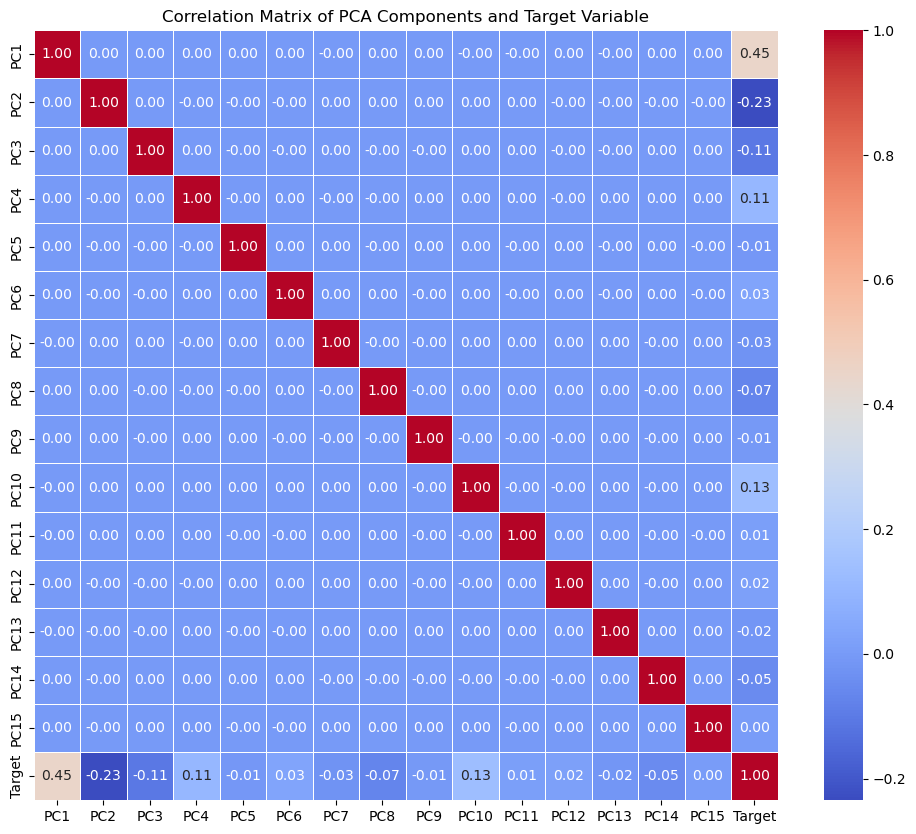

In [161]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your target variable is stored in y_ridge
# If it's named differently, replace y_ridge with your actual target variable name

# Step 1: Create a DataFrame for the PCA components
X_pca_df = pd.DataFrame(
    X_pca, 
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])]
)

# Reset index of y_ridge if necessary and name the column as 'Target'
y_ridge_df = y_ridge.reset_index(drop=True).rename('Target')

# Combine the PCA components and the target variable into one DataFrame
pca_target_df = pd.concat([X_pca_df, y_ridge_df], axis=1)

# Step 2: Compute the correlation matrix
corr_matrix = pca_target_df.corr()

# Display the correlation matrix
print(corr_matrix)

# Step 3: Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=0.5
)
plt.title('Correlation Matrix of PCA Components and Target Variable')
plt.show()


In [148]:
import os
import pickle
X_pca_3d = X_pca[:, :3]
# Create the folder if it doesn't exist
export_folder = 'PCA_visualization'
if not os.path.exists(export_folder):
    os.makedirs(export_folder)

# Define the file paths for the pickled variables
X_pca_3d_path = os.path.join(export_folder, 'X_pca_3d.pkl')
y_ridge_path = os.path.join(export_folder, 'y_ridge.pkl')

# Export the variables using pickle
with open(X_pca_3d_path, 'wb') as f:
    pickle.dump(X_pca_3d, f)
    
with open(y_ridge_path, 'wb') as f:
    pickle.dump(y_ridge, f)

print(f"Variables successfully exported to the folder: {export_folder}")


Variables successfully exported to the folder: PCA_visualization


# Cross validation scheme

I'll use a custom cross validator from Stefan Jansen's github that accepts a multindex dataframe has a class argument.  
* Leave the most recent year out as a holdout set for evaluation
* I'll make my train period 1 year to capture any seasonal effects, and test on half a year
* Using the time seires walk forward approach, data on January 2017 - December 2021 should yield about **6** training and validation sets with **1** holdout test set on the full year  of 2021

In [149]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=121,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(1).unique()
        days = sorted(unique_dates, reverse=True)

        # days = unique_dates
        # days = sorted(unique_dates, reverse=False)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()['Date']
        # self.dates = dates
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates > days[train_start])
                              & (dates <= days[train_end])].index
            test_idx = dates[(dates > days[test_start])
                             & (dates <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

cv = MultipleTimeSeriesCV(n_splits=5, train_period_length=252, test_period_length=100, lookahead=45)

i = 0
for train_idx, test_idx in cv.split(X=X_ridge):
    X_train = X_ridge.iloc[train_idx]
    train_dates = X_train.index.get_level_values(1)
    X_test = X_ridge.iloc[test_idx]
    test_dates = X_test.index.get_level_values(1)
    df = pd.concat((X_train.reset_index(), X_test.reset_index()), axis = 0)
    n = len(df)
    # assert n== len(df.drop_duplicates())
    print(X_train.groupby(level=0).size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          X_test.groupby(level=0).size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break


296 2019-03-08 2020-06-01 100 2020-08-05 2020-12-30
296 2018-10-09 2019-12-26 100 2020-03-09 2020-08-04
296 2018-05-16 2019-07-31 100 2019-10-07 2020-03-06
296 2017-12-14 2019-03-01 100 2019-05-14 2019-10-04
296 2017-07-20 2018-10-01 100 2018-12-05 2019-05-13


# Ridge regression

## Ridge paths

In [172]:
from sklearn.linear_model import HuberRegressor

In [175]:
alphas = np.logspace(1, 6, 30)  
alphas = np.sort(np.append(alphas, np.logspace(4.5, 5.5, 30)))
coefficients_df = pd.DataFrame(index=alphas, columns=X_ridge.columns)
metrics_df = pd.DataFrame(index=alphas, columns=['rmse', 'mae', 'pearson_r'])
metrics_df.index.name='lambda'
coefficients_df.index.name='lambda'

for alpha in alphas:
    rmse_list = []
    mae_list = []
    pearson_list = []
    avg_coefficients = np.zeros(len(X_ridge.columns))  # To accumulate coefficients across CV splits
    
    for i, (train_idx, test_idx) in enumerate(cv.split(X_ridge)):
        ridge_pipe = Pipeline([
            ('scaler', StandardScaler()),  
            ('pca', PCA(n_components=None)),
            # ('ridge', Ridge(alpha=alpha, max_iter=10000, tol=1e-5, random_state=42)),
            ('huber', HuberRegressor(alpha=alpha, max_iter=10000, tol=1e-5))
            
        ])        

        X_train, y_train = X_ridge.iloc[train_idx], y_ridge.iloc[train_idx]
        X_test, y_test = X_ridge.iloc[test_idx], y_ridge.iloc[test_idx]

        ridge_pipe.fit(X_train, y_train)

        avg_coefficients += ridge_pipe.named_steps['huber'].coef_  # Sum the coefficients

        # metrics_df.loc[alpha, 'rmse'] = mean_squared_error(y_test, ypred_test, squared=False)
        # metrics_df.loc[alpha, 'mae'] = mean_absolute_error(y_test, ypred_test)

        ypred_test = ridge_pipe.predict(X_test)
        
        rmse_list.append(mean_squared_error(y_test, ypred_test, squared=False))
        mae_list.append(mean_absolute_error(y_test, ypred_test))
        pearson_list.append(pearsonr(y_test, ypred_test)[0])

    # Average the coefficients across the CV folds
    avg_coefficients /= cv.n_splits
    coefficients_df.loc[alpha, :] = avg_coefficients  # Store coefficients for this alpha

    # Average RMSE and MAE across the CV splits for this alpha
    metrics_df.loc[alpha, 'rmse'] = np.mean(rmse_list)
    metrics_df.loc[alpha, 'mae'] = np.mean(mae_list)
    metrics_df.loc[alpha, 'pearson_r'] = np.mean(pearson_list)



Text(0, 0.5, 'Pearson R')

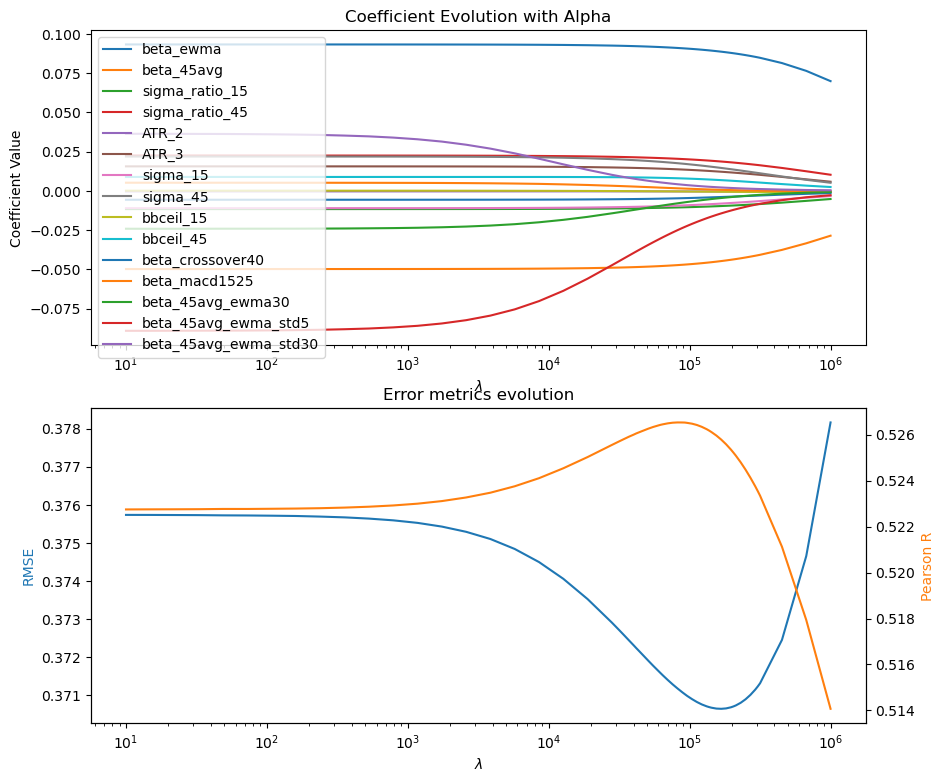

In [177]:
# Plot the coefficient evolution with alpha
fig, ax = plt.subplots(2, 1, figsize=(10,6*1.5))
coefficients_df.plot(logx=True, ax=ax[0], title='Coefficient Evolution with Alpha')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel('Coefficient Value')

ax[1].set_title('Error metrics evolution')
ax1_twin = ax[1].twinx()
sns.lineplot(metrics_df, x='lambda', y='rmse', ax=ax[1])
sns.lineplot(metrics_df, x='lambda', y='pearson_r', ax=ax1_twin, color='tab:orange')

ax[1].set_xscale('log')
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_ylabel('RMSE', color='tab:blue')
ax1_twin.set_ylabel('Pearson R', color='tab:orange')



In [165]:
optimal_ridge_param = metrics_df['rmse'].astype(float).nsmallest(1).index[0]
print('Optimal ridge param is {:.3g}'.format(optimal_ridge_param))

Optimal ridge param is 4.7e+04


## Training the model with optimal regularization

In [166]:
ridge_model_names = [f'ridge_model_{i}' for i in range(cv.n_splits)]
model_metrics = pd.DataFrame(
    index=['rmse', 'mae', 'pearson_r', 'spearman_r'],
    columns=ridge_model_names
)
train_predictions_ridge = pd.DataFrame(index=X_ridge.index, columns=ridge_model_names)

ridge_models = {}
ridge_cv_results = {}  

ridge_params = {
        'alpha': optimal_ridge_param,
        # 'alpha': 92367.085719,  
        'max_iter': 10000,  
        'tol': 1e-5,
        'random_state': 42  
}

for i, (train_idx, test_idx) in enumerate(cv.split(X_ridge)):
    ridge_pipe = Pipeline([
            ('scaler', StandardScaler()),  
            ('ridge', Ridge(**ridge_params)) ]) 

    model_no = f'ridge_model_{i}'
    
    X_train, y_train = X_ridge.iloc[train_idx], y_ridge.iloc[train_idx]
    X_test, y_test = X_ridge.iloc[test_idx], y_ridge.iloc[test_idx]

    
    ridge_pipe.fit(X_train, y_train)

    ridge_models[model_no] = ridge_pipe
    ypred_test = ridge_pipe.predict(X_test)

    model_metrics.loc['rmse', model_no] = mean_squared_error(y_test, ypred_test, squared=False)
    model_metrics.loc['mae', model_no] = mean_absolute_error(y_test, ypred_test)
    model_metrics.loc['pearson_r', model_no] = pearsonr(y_test, ypred_test)[0]
    model_metrics.loc['spearman_r', model_no] = spearmanr(y_test, ypred_test)[0]

    train_predictions_ridge.loc[:, model_no] = ridge_pipe.predict(X_ridge)
    

# View the metrics for Ridge regression
display(model_metrics)


ridge_model_0 ridge_model_1 ridge_model_2 ridge_model_3  \
rmse            0.348892      0.391612      0.371065      0.378922   
mae             0.270842       0.30988      0.278744      0.272426   
pearson_r       0.420478      0.567009      0.453188      0.562629   
spearman_r       0.41948      0.561894      0.483313      0.595998   

           ridge_model_4  
rmse            0.364867  
mae             0.277524  
pearson_r       0.636973  
spearman_r      0.623573

## Feature importance

ridge_model_0  ridge_model_1  ridge_model_2  \
beta_ewma                   0.117329       0.100679       0.099793   
beta_45avg                  0.061056       0.063531       0.045023   
sigma_ratio_15             -0.001071      -0.028167      -0.004993   
sigma_ratio_45             -0.013992      -0.018919       0.003298   
ATR_2                       0.007030       0.009575       0.006554   
ATR_3                       0.013158       0.012213       0.009660   
sigma_15                    0.003494       0.034501       0.024531   
sigma_45                    0.033933       0.025954       0.039787   
bbceil_15                  -0.016684       0.004758      -0.005155   
bbceil_45                   0.048602       0.045002       0.025579   
beta_crossover40           -0.026762      -0.007584      -0.005931   
beta_macd1525              -0.029741      -0.026638      -0.032409   
beta_45avg_ewma30           0.059322       0.071009       0.060032   
beta_45avg_ewma_std5        0.001612      -0.005584      -0.002948   
beta_45avg_ewma_std30      -0.002703       0.004993       0.014758   

                       ridge_model_3  ridge_model_4  
beta_ewma                   0.093312       0.093457  
beta_45avg                  0.028039       0.016218  
sigma_ratio_15              0.001068      -0.005184  
sigma_ratio_45              0.027149       0.014220  
ATR_2                       0.002509       0.001293  
ATR_3                       0.006077       0.003697  
sigma_15                    0.009776       0.016714  
sigma_45                    0.043241       0.038011  
bbceil_15                  -0.008265      -0.005380  
bbceil_45                   0.033460       0.016218  
beta_crossover40           -0.024373      -0.019290  
beta_macd1525              -0.042784      -0.038670  
beta_45avg_ewma30           0.040176       0.031419  
beta_45avg_ewma_std5       -0.003351      -0.003781  
beta_45avg_ewma_std30       0.017141       0.008683

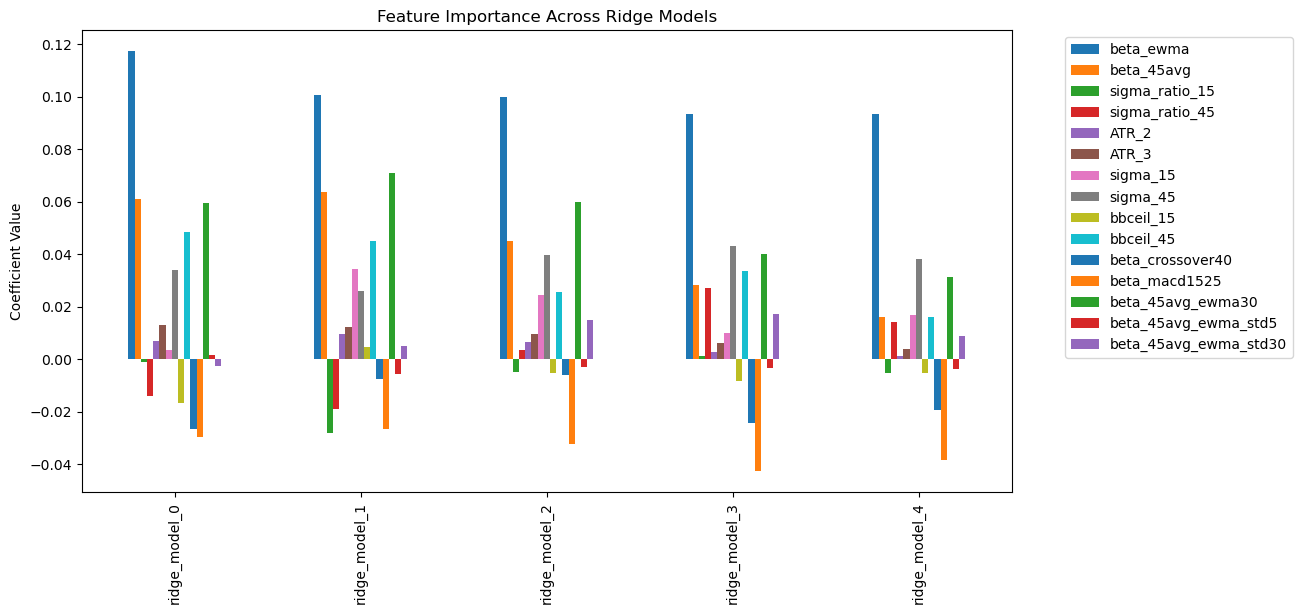

In [167]:
feature_importance_df = pd.DataFrame(index=beta_feature_list)

for model_no, model in ridge_models.items():
    feature_importance_df[model_no] = ridge_models[model_no].named_steps['ridge'].coef_

display(feature_importance_df)    

feature_importance_df.T.plot(kind='bar', figsize=(12, 6), title='Feature Importance Across Ridge Models')
plt.ylabel('Coefficient Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.show()

## Evaluation and metrics

In [168]:
# DEFINE MODEL WEIGHTS FOR BLENDING
model_metrics.loc['pearson_weight'] = model_metrics.loc['pearson_r'] / model_metrics.loc['pearson_r'].sum()
model_metrics.loc['mae_weight'] = model_metrics.loc['mae'] / model_metrics.loc['mae'].sum()
weighting_metric = 'mae_weight'


# BLEND TRAINING PREDICTIONS
train_predictions_ridge['blended_prediction'] =(train_predictions_ridge * model_metrics.loc[weighting_metric]).sum(axis=1).astype(float)
train_predictions_ridge['actual'] = y_ridge


## FOR BACKGROUND ADDITION ##
# train_predictions_ridge['blended_residual_prediction'] = (train_predictions_ridge * model_metrics.loc[weighting_metric]).sum(axis=1).astype(float)
# train_predictions_ridge['target_prediction'] = train['target_background'] + train_predictions_ridge['blended_residual_prediction']


# train_predictions_ridge['actual_residual'] = y_ridge
# train_predictions_ridge['actual_target'] = train['target_background'] + train_predictions_ridge['actual_residual']



# GENERATE PREDICTIONS FOR HOLDOUT SET

holdout_predictions_ridge = pd.DataFrame(columns=ridge_model_names, index=y_holdout.index)
holdout_metrics_ridge = pd.DataFrame(index=model_metrics.index, columns=model_metrics.columns)

for key in ridge_models.keys():
    model = ridge_models[key]
    # ypred_train = model.predict(X_ridge)
    # train_predictions_ridge[key] = ypred_train

    ypred_holdout = model.predict(X_holdout)
    holdout_predictions_ridge[key] = model.predict(X_holdout)

    holdout_metrics_ridge.loc['rmse', key] = mean_squared_error(ypred_holdout, y_holdout, squared=False)
    holdout_metrics_ridge.loc['mae', key] = mean_absolute_error(ypred_holdout, y_holdout)
    holdout_metrics_ridge.loc['pearson_r', key] = pearsonr(ypred_holdout, y_holdout)[0]
    holdout_metrics_ridge.loc['spearman_r', key] = spearmanr(ypred_holdout, y_holdout)[0]

holdout_metrics_ridge.loc['pearson_weight'] = holdout_metrics_ridge.loc['pearson_r'] / holdout_metrics_ridge.loc['pearson_r'].sum()
holdout_metrics_ridge.loc['mae_weight'] = holdout_metrics_ridge.loc['mae'] / holdout_metrics_ridge.loc['mae'].sum()


holdout_predictions_ridge['blended_prediction'] = (holdout_predictions_ridge * holdout_metrics_ridge.loc[weighting_metric]).sum(axis=1).astype(float)
holdout_predictions_ridge['actual'] = y_holdout

### FOR BACKGROUND ADDITION ###
# holdout_predictions_ridge['blended_residual_prediction'] = (holdout_predictions_ridge * holdout_metrics_ridge.loc[weighting_metric]).sum(axis=1).astype(float)
# holdout_predictions_ridge['actual_residual'] = y_holdout
# holdout_predictions_ridge['actual_target'] = train['target_background'] + holdout_predictions_ridge['actual_residual']
# holdout_predictions_ridge['target_prediction'] = train['target_background'] + holdout_predictions_ridge['blended_residual_prediction']

# DEFINE THE TIME RESOLVED METRICS DATAFRAME

metrics_time = pd.DataFrame(index = train_predictions_ridge.index.get_level_values('Date').unique())


# for col in ['actual_target', 'target_prediction']:
#     print(col)
#     train_predictions_ridge[col]
#     print('did the first one')

#     train_predictions_ridge[f'{col}_beta'] = johnson_su_inverse_transform(train_predictions_ridge[col], jsu_params)
#     holdout_predictions_ridge[f'{col}_beta'] = johnson_su_inverse_transform(holdout_predictions_ridge[col], jsu_params)

In [169]:
def plot_actual_vs_predicted(train_df, holdout_df, model_name='Model', actual_col='actual_target', predicted_col='target_prediction'):
    """
    Plots actual vs. predicted values for training and holdout sets,
    and computes Pearson r, RMSE, and MAE for both sets.

    Parameters:
    - train_df: DataFrame containing the training set with actual and predicted values.
    - holdout_df: DataFrame containing the holdout set with actual and predicted values.
    - model_name: String representing the name of the model (for plot titles).
    - actual_col: Name of the column with actual target values.
    - predicted_col: Name of the column with predicted values.
    """
    # Compute metrics for training set
    y_train_actual = train_df[actual_col]
    y_train_pred = train_df[predicted_col]
    pearson_train = pearsonr(y_train_actual, y_train_pred)[0]
    rmse_train = mean_squared_error(y_train_actual, y_train_pred, squared=False)
    mae_train = mean_absolute_error(y_train_actual, y_train_pred)

    # Compute metrics for holdout set
    y_holdout_actual = holdout_df[actual_col]
    y_holdout_pred = holdout_df[predicted_col]
    pearson_holdout = pearsonr(y_holdout_actual, y_holdout_pred)[0]
    rmse_holdout = mean_squared_error(y_holdout_actual, y_holdout_pred, squared=False)
    mae_holdout = mean_absolute_error(y_holdout_actual, y_holdout_pred)

    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    axa, axb = ax

    # Plot for training set
    sns.scatterplot(x=y_train_pred, y=y_train_actual, alpha=0.3, ax=axa)
    axa.set_title(f'TRAINING SET\n{model_name}\nPearson r={pearson_train:.3g}\n'+f'RMSE: {rmse_train:.3f}\nMAE: {mae_train:.3f}', fontsize=14)
    axa.set_xlabel('Predicted Values')
    axa.set_ylabel('Actual Values')

    

    # Add metrics text
    # axa.text(0.95, 0.95, f'RMSE: {rmse_train:.3f}\nMAE: {mae_train:.3f}',
            #  transform=axa.transAxes, fontsize=12, verticalalignment='top')

    # Plot for holdout set
    sns.scatterplot(x=y_holdout_pred, y=y_holdout_actual, alpha=0.3, ax=axb)
    axb.set_title(f'HOLDOUT SET\n{model_name}\nPearson r={pearson_holdout:.3g}\n'+f'RMSE: {rmse_holdout:.3f}\nMAE: {mae_holdout:.3f}', fontsize=14)
    axb.set_xlabel('Predicted Values')
    axb.set_ylabel('Actual Values')

    # Add metrics text
    # axb.text(0.95, 0.95, f'RMSE: {rmse_holdout:.3f}\nMAE: {mae_holdout:.3f}',
    #          transform=axb.transAxes, fontsize=12, verticalalignment='top')

    # Plot y = x line
    for a in [axa, axb]:
        a.set_xlim(a.get_xlim())
        a.set_ylim(a.get_ylim())
        a.plot(a.get_xlim(), a.get_xlim(), '--', color='tab:orange', linewidth=3, label='y=x')
    
    axa.legend(fontsize=12)



    # Display metrics
    print("Training Set Metrics:")
    print(f"Pearson r: {pearson_train:.3f}")
    print(f"RMSE: {rmse_train:.3f}")
    print(f"MAE: {mae_train:.3f}\n")

    print("Holdout Set Metrics:")
    print(f"Pearson r: {pearson_holdout:.3f}")
    print(f"RMSE: {rmse_holdout:.3f}")
    print(f"MAE: {mae_holdout:.3f}")





### Predicted versus acutal

Training Set Metrics:
Pearson r: 0.523
RMSE: 0.357
MAE: 0.270

Holdout Set Metrics:
Pearson r: 0.520
RMSE: 0.274
MAE: 0.213
Training Set Metrics:
Pearson r: 0.546
RMSE: 0.352
MAE: 0.265

Holdout Set Metrics:
Pearson r: 0.520
RMSE: 0.276
MAE: 0.215


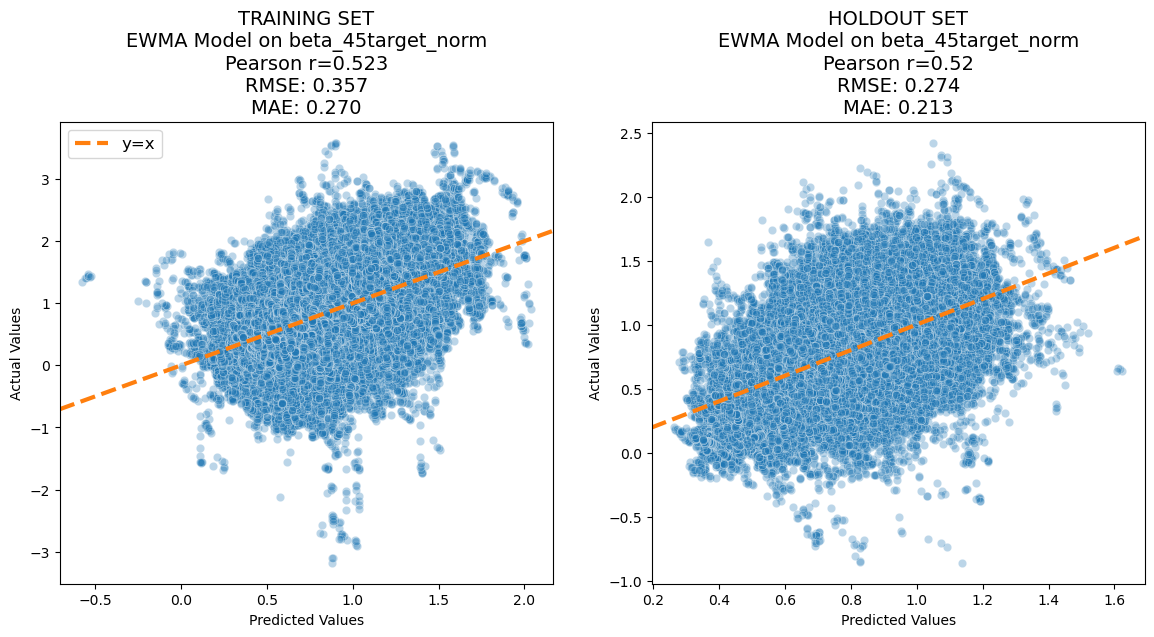

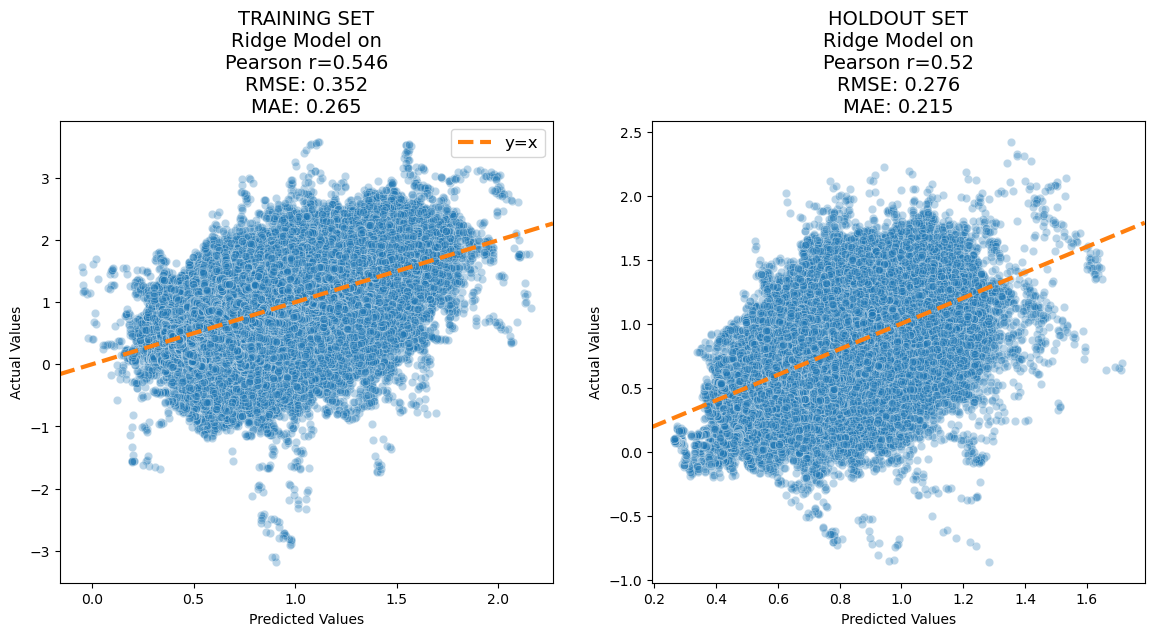

In [170]:
plot_actual_vs_predicted(
    train_df=train_predictions_baseline,
    holdout_df=holdout_predictions_baseline,
    model_name='EWMA Model on beta_45target_norm',
    actual_col='actual',
    predicted_col='ewma_prediction'
)

plot_actual_vs_predicted(
    train_df=train_predictions_ridge,
    holdout_df=holdout_predictions_ridge,
    model_name='Ridge Model on',
    actual_col='actual',
    predicted_col='blended_prediction'
)


<Axes: xlabel='Date', ylabel='actual'>

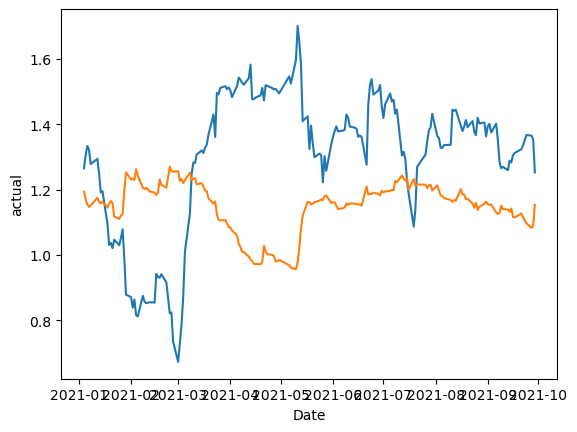

In [105]:
fig, ax = plt.subplots()

sns.lineplot(holdout_predictions_ridge.loc[6407], x='Date', y='actual')
sns.lineplot(holdout_predictions_ridge.loc[6407], x='Date', y='blended_prediction')

### Daily pooled error metrics

In [75]:
def compute_pooled_metrics(df:pd.DataFrame, levels:list):
    '''
    Computes 4 metrics pooled by a list of levels in a pandas dataframe.
    df should only have two columnes, the predcited and the actual target values.
    '''
    outputs = {}
    for level in levels:
        metric_pool_df = pd.DataFrame(
            index = df.index.get_level_values(level).unique())

        metric_pool_df['rmse'] = df.groupby(level, group_keys=False).apply(
            lambda x: mean_squared_error(*x.values.T, squared=False))         
        metric_pool_df['mae'] = df.groupby(level, group_keys=False).apply(
            lambda x: mean_absolute_error(*x.values.T)) 
        metric_pool_df['pearson_r'] = df.groupby(level, group_keys=False).apply(
            lambda x: pearsonr(*x.values.T)[0])
        metric_pool_df['spearman_r'] = df.groupby(level, group_keys=False).apply(
            lambda x: spearmanr(*x.values.T)[0])  
    
        outputs[f'{level}_pool'] = metric_pool_df
    
    return outputs

def plot_time_metrics(baseline_metrics_df, metrics_df:pd.DataFrame, model_name:str):
    assert (baseline_metrics_df.columns == metrics_df.columns).all()
    columns = metrics_df.columns
    n = len(columns)
    fig, ax = plt.subplots(n, 1, figsize=(9.2, 5.6*n*2/3))
    fig.subplots_adjust(hspace= 0.5)
    for i, col in enumerate(columns):
        metric_mean = metrics_df[col].mean()
        baseline_metric_mean = baseline_metrics_df[col].mean()
        ax[i].set_title('Mean daily baseline {:} = {:.3g}\nMean daily {:} {:} = {:.3g}'.format(
            col, baseline_metric_mean, model_name, col, metric_mean))
        ax[i].axhline(baseline_metric_mean, color='tab:blue', linestyle='--')
        ax[i].axhline(metric_mean, color='tab:orange', linestyle='--')
        
        sns.lineplot(baseline_metrics_df, x=metrics_df.index.name, y=col, ax=ax[i], marker='o', label='baseline')
        sns.lineplot(metrics_df, x=metrics_df.index.name, y=col, ax=ax[i], marker='o', label=model_name)
        ax[i].legend()
    return

In [76]:


# Naive baseline pooling
result = compute_pooled_metrics(
    df=train_predictions_baseline[['naive_prediction', 'actual']],
    levels=['Code', 'Date']
)
naive_training_metrics_time = result['Date_pool']
naive_training_metrics_code = result['Code_pool']

result = compute_pooled_metrics(
    df=holdout_predictions_baseline[['naive_prediction', 'actual']],
    levels=['Code', 'Date']
)
naive_holdout_metrics_time = result['Date_pool']
naive_holdout_metrics_code = result['Code_pool']



# EWMA baseline pooling
result = compute_pooled_metrics(
    df=train_predictions_baseline[['ewma_prediction', 'actual']],
    levels=['Code', 'Date']
)
ewma_training_metrics_time = result['Date_pool']
ewma_training_metrics_code = result['Code_pool']

result = compute_pooled_metrics(
    df=holdout_predictions_baseline[['ewma_prediction', 'actual']],
    levels=['Code', 'Date']
)
ewma_holdout_metrics_time = result['Date_pool']
ewma_holdout_metrics_code = result['Code_pool']



# Ridge regression pooling
result = compute_pooled_metrics(
    df=train_predictions_ridge[['blended_residual_prediction', 'actual_residual']], 
    levels=['Code', 'Date'])

ridge_training_metrics_time = result['Date_pool']
ridge_training_metrics_code = result['Code_pool']
# universe_stats.merge(result['Code_pool'], how='left', on='Code', inplace=True)

result = compute_pooled_metrics(
    df=holdout_predictions_ridge[['blended_residual_prediction', 'actual_residual']],
    levels=['Code', 'Date'])
ridge_holdout_metrics_time = result['Date_pool']
ridge_holdout_metrics_code = result['Code_pool']


del result


#### Training set

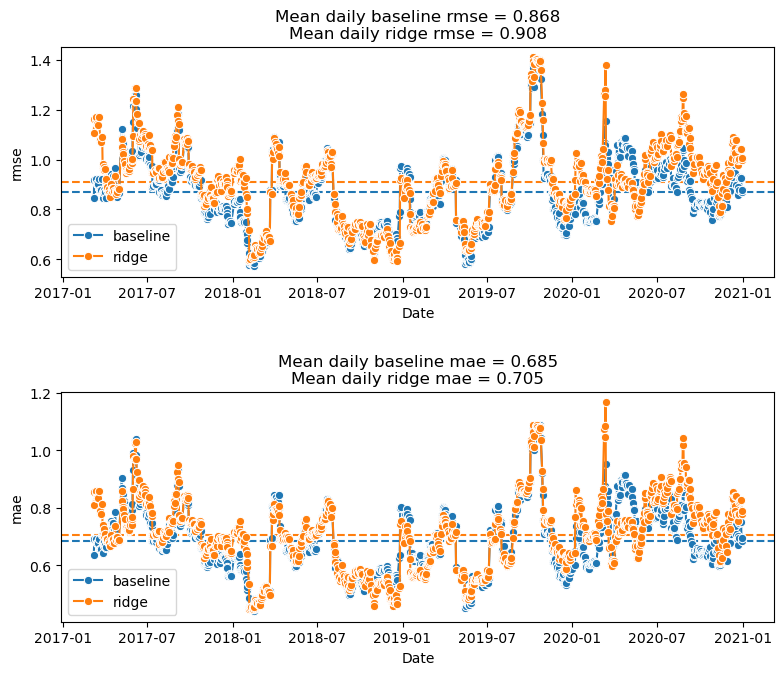

In [77]:
plot_time_metrics(
    baseline_metrics_df=ewma_training_metrics_time[['rmse', 'mae']],
    # baseline_metrics_df=naive_training_metrics_time,
    metrics_df=ridge_training_metrics_time[['rmse', 'mae']],
    model_name='ridge')

#### Holdout set

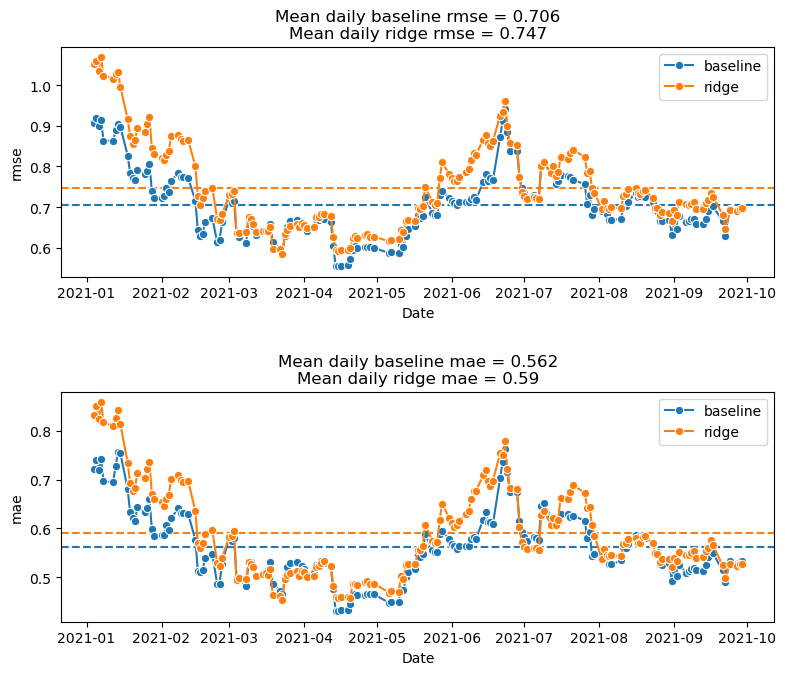

In [78]:
plot_time_metrics(
    baseline_metrics_df=ewma_holdout_metrics_time[['rmse', 'mae']], 
    # baseline_metrics_df=naive_holdout_metrics_time,
    metrics_df=ridge_holdout_metrics_time[['rmse', 'mae']], 
    model_name='ridge')

In [224]:
# fig, ax = plt.subplots(1, 2, figsize=(9.2 * 1.5, 5.6))
# axa, axb = ax

# # AXA
# pearson_train = pearsonr(*train_predictions_ridge[['target_prediction', 'actual_target']].values.T)[0]
# axa.set_title('TRAINING SET\nRidge model Pearson r={:.3g}'.format(pearson_train), fontsize=17)

# sns.scatterplot(x='blended_prediction', y='actual_target', alpha=0.3, data=train_predictions_ridge, ax=axa)


# axa.set_xlim(axa.get_xlim())
# axa.set_ylim(axa.get_ylim())
# axa.plot(axa.get_xlim(), axa.get_xlim(), '--', color='tab:orange', linewidth=3, label='y=x')
# axa.legend(fontsize=17)

# # AXB
# pearson_holdout = pearsonr(*holdout_predictions_ridge[['target_prediction', 'actual_target']].values.T)[0]
# axb.set_title('HOLDOUT SET\nRidge model Pearson r={:.3g}'.format(pearson_holdout), fontsize=17)
# sns.scatterplot(x='target_prediction', y='actual_target', alpha=0.3, data=holdout_predictions_ridge, ax=axb)

# axb.set_xlim(axb.get_xlim())
# axb.set_ylim(axb.get_ylim())
# axb.plot(axb.get_xlim(), axb.get_xlim(), '--', color='tab:orange', linewidth=3, label='y=x')


# display(holdout_metrics_ridge)


In [84]:
mean_squared_error(train_predictions_ridge['actual_target']/2, train_predictions_ridge['target_prediction'], squared=False)

0.46818522671254836

Text(0.5, 1.075, 'HOLDOUT\nRidge model residuals RMSE 1.01')

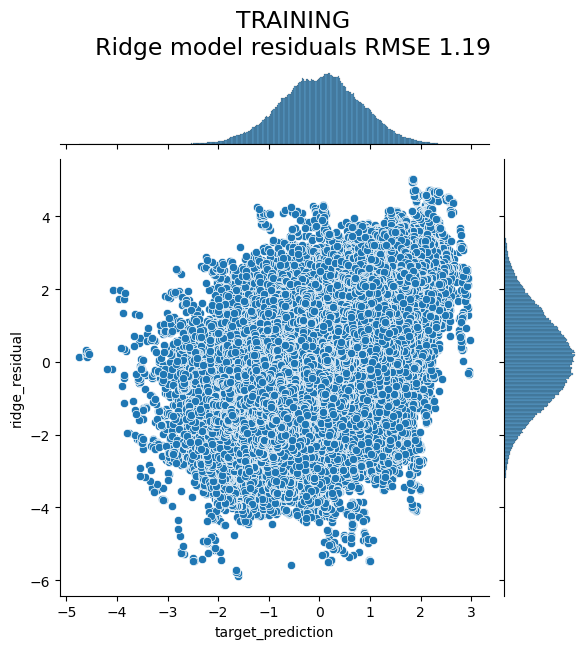

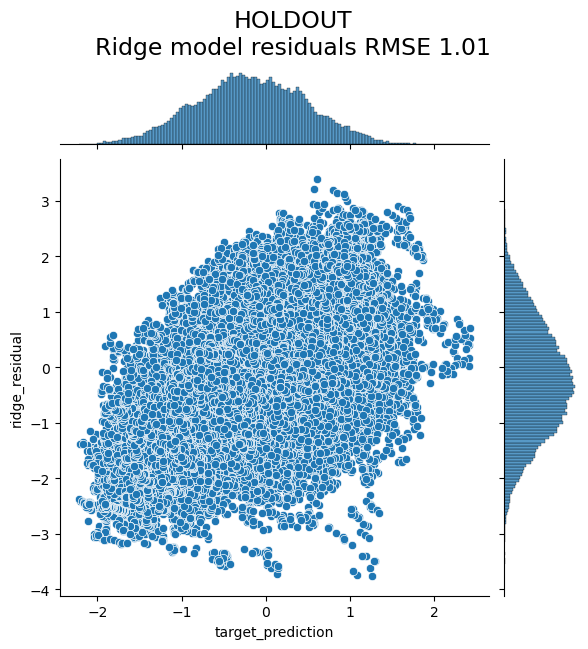

In [81]:
ridge_train_rmse = mean_squared_error(*train_predictions_ridge[['actual_target', 'target_prediction']].values.T, squared=False)
train_predictions_ridge['ridge_residual'] = train_predictions_ridge['actual_target'] - train_predictions_ridge['target_prediction']

j_train_ridge = sns.jointplot(x=train_predictions_ridge['target_prediction'], y=train_predictions_ridge['ridge_residual'])
plt.suptitle('TRAINING\nRidge model residuals RMSE {:.3g}'.format(ridge_train_rmse), y=1.075, fontsize=17)


ridge_holdout_rmse = mean_squared_error(*holdout_predictions_ridge[['actual_target', 'target_prediction']].values.T, squared=False)
holdout_predictions_ridge['ridge_residual'] = holdout_predictions_ridge['actual_target'] - holdout_predictions_ridge['target_prediction']

j_holdout_ridge = sns.jointplot(x=holdout_predictions_ridge['target_prediction'], y=holdout_predictions_ridge['ridge_residual'])
plt.suptitle('HOLDOUT\nRidge model residuals RMSE {:.3g}'.format(ridge_holdout_rmse), y=1.075, fontsize=17)


## Ridge regresion model evaulation

* Ridge regression barely outperforms the baseline with a pearson correlation of around 0.575 in the holdout set.
* The difference in the Ridge model's RMSE and baseline RMSE is nelgibile

<font size = 6>

* Better quality feature engineering is needed to make the ridge model outperform the baseline.
* Nonlinear modeling could do better.  Should strongly consider kernalized (ridge/huber) regression.


# Final model evaluation

<!-- # XGBoost
* My knowledge of XGBoost is still growing but the key ingredients come from 
    * Gradient boosting (core algo is adaboost)
    * Random forests and decision trees
    * L1 and L2 regularization -->